In [1]:
#importa√ß√µes;
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import differential_evolution, minimize
import statistics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Transformando os dados em %

In [2]:
# Popula√ß√£o total de cada regi√£o
populacao_total = {
    'NORTE': 14779178,
    'NORDESTE': 54428540,
    'SUDESTE': 83955553,
    'SUL': 28954866,
    'CENTROOESTE': 15326392
}

# M√©dia de casos mensais por regi√£o
media_casos_mensais = {
    'NORTE': [867.6363636, 801.3636364, 932.2727273, 907.8181818, 929.4545455, 911.6363636, 904.9090909, 929.9090909, 888, 863.3636364, 842.2727273, 679.3636364],
    'NORDESTE': [2035.454545, 1858.363636, 2095.363636, 1959.181818, 2026.090909, 1872.090909, 2031.909091, 2106.181818, 1947.636364, 1974.727273, 1811.818182, 1449.181818],
    'SUDESTE': [3521.090909, 3183.181818, 3746.818182, 3284.636364, 3341.545455, 3275.181818, 3443.090909, 3615.636364, 3461.090909, 3489.272727, 3207.090909, 2673],
    'SUL': [950.4545455, 842.2727273, 948.3636364, 907, 903.7272727, 878.1818182, 938.2727273, 1013, 944.2727273, 977.4545455, 887.0909091, 739.1818182],
    'CENTROOESTE': [367.3636364, 342.8181818, 417.4545455, 369.1818182, 374.2727273, 359.0909091, 368.1818182, 384.8181818, 366.5454545, 366.5454545, 332.7272727, 265.1818182]
}

# Convertendo a m√©dia de casos mensais em porcentagem da popula√ß√£o total de cada regi√£o
media_casos_percentual = {regiao: [casos / populacao_total[regiao] * 100 for casos in medias]
                          for regiao, medias in media_casos_mensais.items()}

# Criando um DataFrame para visualizar os resultados
df_percentual = pd.DataFrame(media_casos_percentual, index=[f'M√™s {i+1}' for i in range(12)])

df_percentual

NORTE  NORDESTE   SUDESTE       SUL  CENTROOESTE
M√™s 1   0.005871  0.003740  0.004194  0.003283     0.002397
M√™s 2   0.005422  0.003414  0.003792  0.002909     0.002237
M√™s 3   0.006308  0.003850  0.004463  0.003275     0.002724
M√™s 4   0.006143  0.003600  0.003912  0.003132     0.002409
M√™s 5   0.006289  0.003722  0.003980  0.003121     0.002442
M√™s 6   0.006168  0.003440  0.003901  0.003033     0.002343
M√™s 7   0.006123  0.003733  0.004101  0.003240     0.002402
M√™s 8   0.006292  0.003870  0.004307  0.003499     0.002511
M√™s 9   0.006008  0.003578  0.004123  0.003261     0.002392
M√™s 10  0.005842  0.003628  0.004156  0.003376     0.002392
M√™s 11  0.005699  0.003329  0.003820  0.003064     0.002171
M√™s 12  0.004597  0.002663  0.003184  0.002553     0.001730

# ESSE C√ìDIGO, COSTUMA DEMORAR PARA RODAR, SE TIVER UM HPC, RODE NO HPC!
# Fun√ß√£o para calcular as derivadas do modelo SIR
def SIR_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta):
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I
    return dS_dt, dI_dt, dR_dt

# Fun√ß√£o para remover outliers usando o m√©todo do Z-score
def remove_outliers(data, threshold=1.5):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(x - mean) / std_dev for x in data]
    return [x for x, z in zip(data, z_scores) if abs(z) < threshold]

# Fun√ß√£o para simular o modelo SIR com m√©todo de Euler
def euler_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS, dI, dR = SIR_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta)
        S += dS * dt
        I += dI * dt
        R += dR * dt
        
        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total
        
        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# Fun√ß√£o para simular o modelo SIR com m√©todo de Runge-Kutta de 4¬™ Ordem
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS1, dI1, dR1 = SIR_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta)
        dS2, dI2, dR2 = SIR_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta)
        dS3, dI3, dR3 = SIR_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta)
        dS4, dI4, dR4 = SIR_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6

        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# Fun√ß√£o de simula√ß√£o do modelo SIR para infectados usando RK4
def simulate_sir_rk4(beta_f, S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta):
    _, _, I_rk4, _ = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta)
    return I_rk4

# Fun√ß√£o de erro para minimizar usando RK4 (m√©dia quadr√°tica)
def erro(beta_f, S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta, dias_medicao, dados_observados):
    I_rk4 = simulate_sir_rk4(beta_f, S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta)
    I_medicao = [I_rk4[int(dia / dt)] for dia in dias_medicao]
    erro_total = np.mean((np.array(I_medicao) - np.array(dados_observados)) ** 2)
    return erro_total

# Ajustar limites para otimiza√ß√£o e definir par√¢metros iniciais
bounds = [(0, 1)]  # Apenas beta
max_iter_de = 100  # Aumentar o n√∫mero de itera√ß√µes para Differential Evolution

# Definindo os valores iniciais de S, I e R para cada regi√£o
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Definindo os valores de gamma para cada regi√£o
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada regi√£o
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Dados de casos observados para cada regi√£o
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dicion√°rios para armazenar dados sem outliers por regi√£o
dados_observados_sem_outliers_regioes = {}
dias_medicao_sem_outliers_regioes = {}

# Otimizar o par√¢metro beta para cada regi√£o ap√≥s remover outliers
parametros_otimizados_hibridos = {}
for regiao, valores in valores_iniciais.items():
    S0, I0, R0 = valores['S0'], valores['I0'], valores['R0']
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    dados_observados = media_casos_percentual[regiao]

    # Remover outliers dos dados observados usando Z-score
    dados_observados_sem_outliers = remove_outliers(dados_observados)
    
    # Armazenar dados sem outliers para a regi√£o
    dados_observados_sem_outliers_regioes[regiao] = dados_observados_sem_outliers
    
    # Ajustar dias de medi√ß√£o correspondentes aos dados observados sem outliers
    dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
    dias_medicao_sem_outliers = [dias_medicao[i] for i in range(len(dados_observados)) if dados_observados[i] in dados_observados_sem_outliers]
    
    # Armazenar dias sem outliers para a regi√£o
    dias_medicao_sem_outliers_regioes[regiao] = dias_medicao_sem_outliers
    
    # Otimiza√ß√£o com Differential Evolution
    resultado_de = differential_evolution(erro, bounds, args=(S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta, dias_medicao_sem_outliers, dados_observados_sem_outliers), maxiter=max_iter_de)
    
    # Refinar com L-BFGS-B
    resultado_lbfgsb = minimize(erro, resultado_de.x, args=(S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta, dias_medicao_sem_outliers, dados_observados_sem_outliers), 
                                bounds=bounds, method='L-BFGS-B')
    
    # Salvando o par√¢metro otimizado
    parametros_otimizados_hibridos[regiao] = resultado_lbfgsb.x[0]

    # Imprimir o par√¢metro otimizado para cada regi√£o
    print(f"Par√¢metro otimizado para a regi√£o {regiao} (sem outliers): Beta = {resultado_lbfgsb.x[0]:.4f}")

# Gerar gr√°ficos das curvas de infectados com o par√¢metro otimizado usando RK4
for regiao, valores in valores_iniciais.items():
    # Valores iniciais para a regi√£o
    S0, I0, R0 = valores['S0'], valores['I0'], valores['R0']
    beta_f = parametros_otimizados_hibridos[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    
    # Recuperar dados sem outliers para a regi√£o
    dados_observados_sem_outliers = dados_observados_sem_outliers_regioes[regiao]
    dias_medicao_sem_outliers = dias_medicao_sem_outliers_regioes[regiao]
    
    # Executar o modelo SIR com o par√¢metro otimizado usando RK4
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta)
    
    # Plotar o resultado
    plt.figure(figsize=(12, 8))
    plt.plot(times_rk4, I_rk4, label=f'RK4 - Infectados ({regiao})', color='blue')
    plt.scatter(dias_medicao_sem_outliers, dados_observados_sem_outliers, color='black', label=f'Dados Observados ({regiao}) (Sem Outliers)', zorder=5)
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual de Infectados')
    plt.title(f'Curva de Infectados com Par√¢metro Otimizado - {regiao} (Sem Outliers)')
    plt.legend()
    plt.show()

'''
Os valores encontrados devem ser;
Par√¢metro otimizado para a regi√£o NORTE (sem outliers): Beta = 0.0107
Par√¢metro otimizado para a regi√£o NORDESTE (sem outliers): Beta = 0.0099
Par√¢metro otimizado para a regi√£o SUDESTE (sem outliers): Beta = 0.0098
Par√¢metro otimizado para a regi√£o SUL (sem outliers): Beta = 0.0097
Par√¢metro otimizado para a regi√£o CENTROOESTE (sem outliers): Beta = 0.0098
'''

# Agora que sabemos um beta base para cada regi√£o considerando um crescimento populacional estavel, vamos fazer algumas altera√ß√µes

- Vamos adicionar os dados de nascimento e morte de cada regi√£o;
- Vamos alterar o beta para os novos dados adicionados ao modelo; e
- Vamos implementar o modelo SIRS.

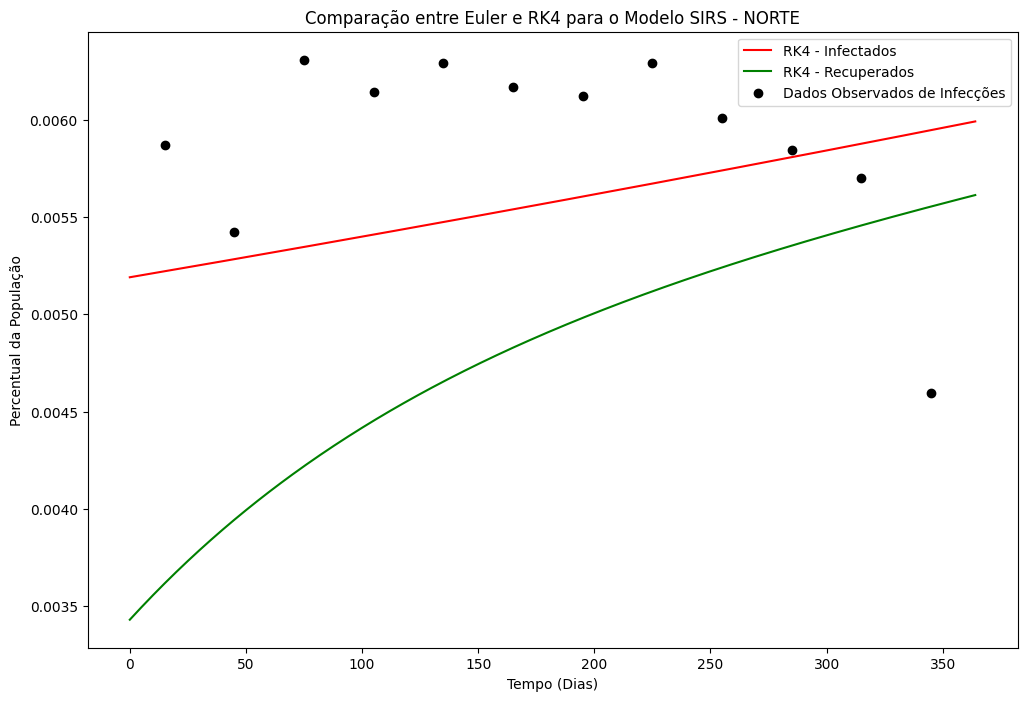

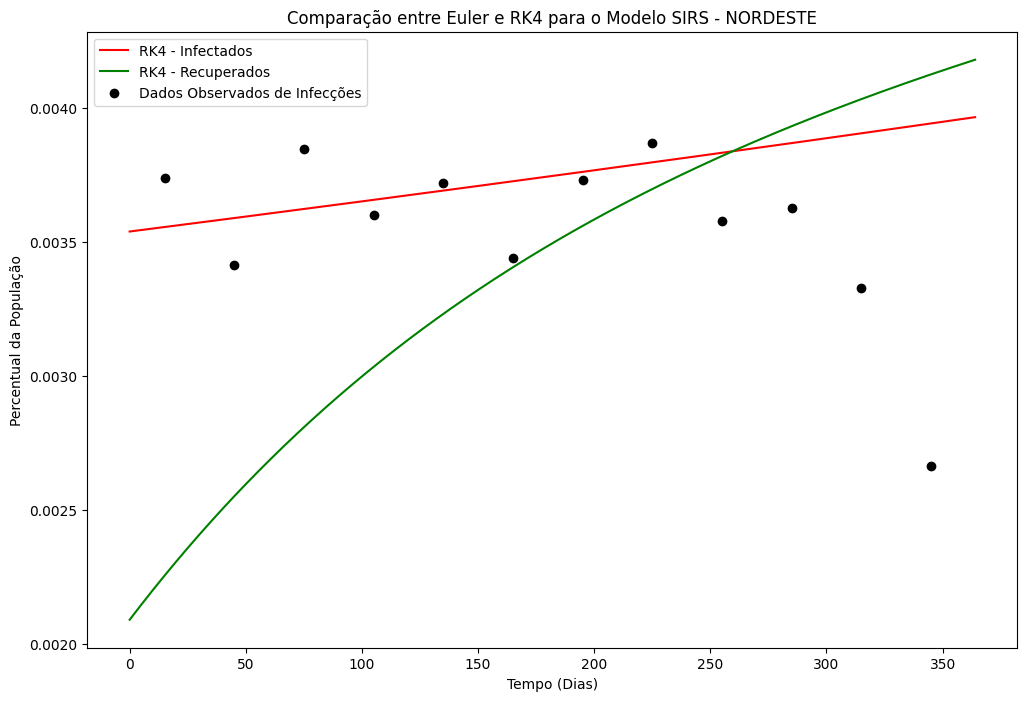

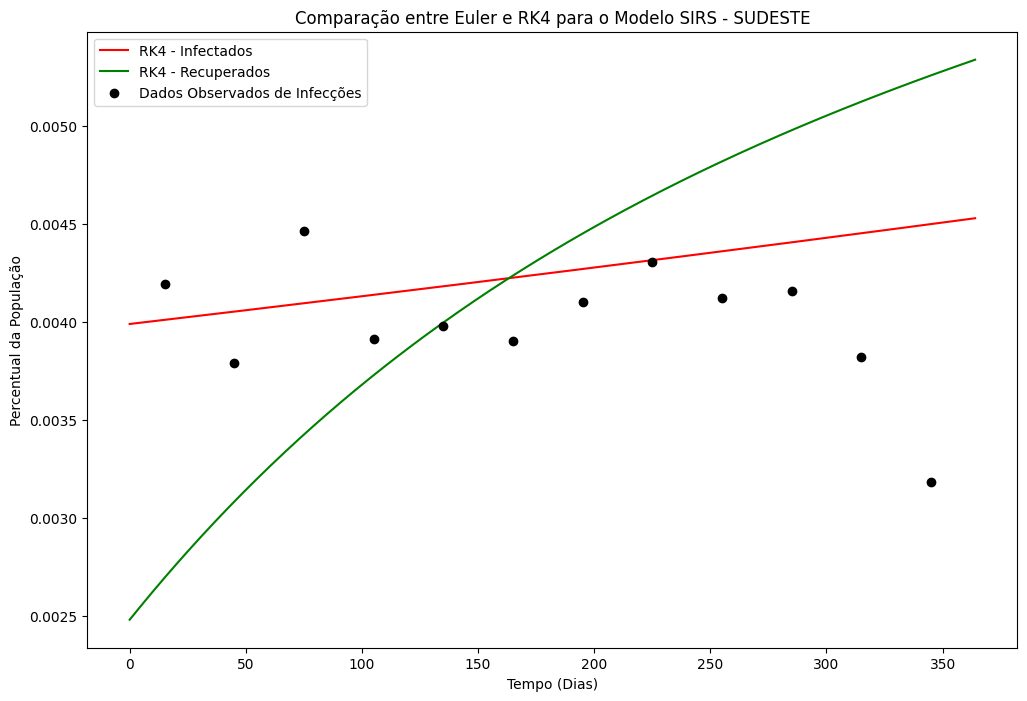

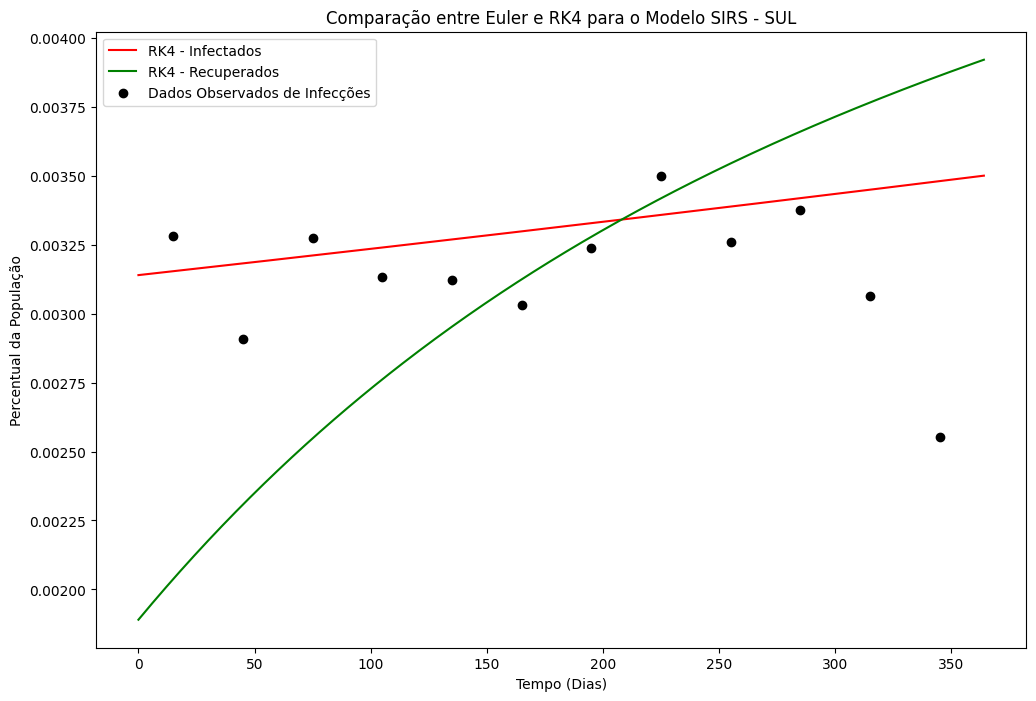

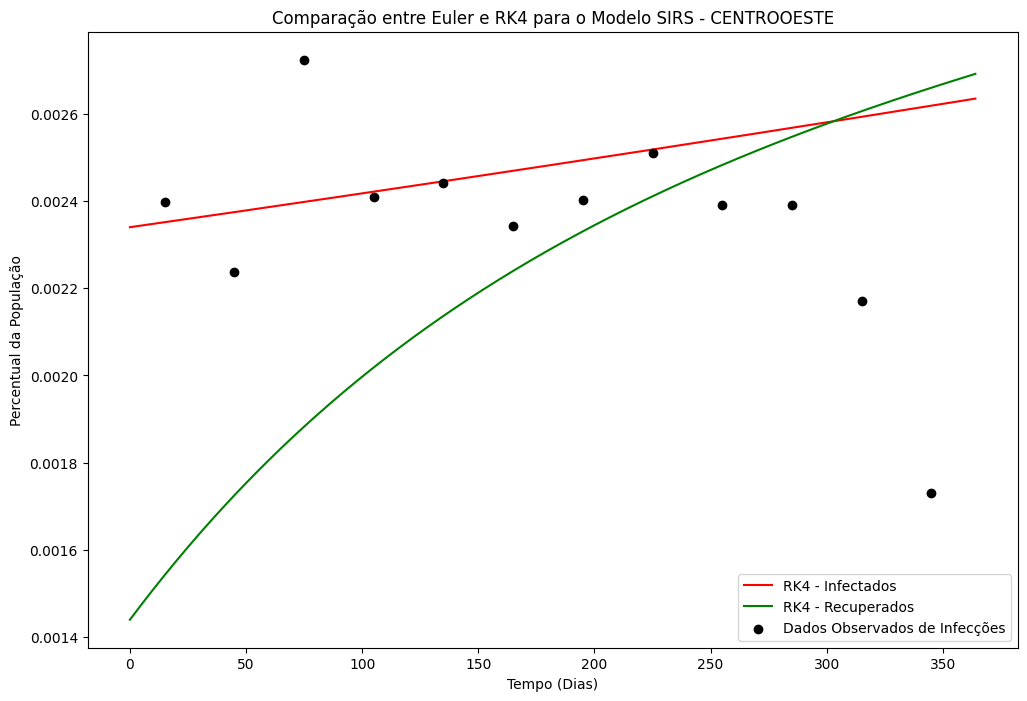

In [3]:
# Fun√ß√£o para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equa√ß√µes SIRS.
    
    Par√¢metros:
    - S: Popula√ß√£o suscet√≠vel (%)
    - I: Popula√ß√£o infectada (%)
    - R: Popula√ß√£o recuperada (%)
    - beta_f: Taxa de transmiss√£o
    - gamma_f: Taxa de recupera√ß√£o
    - mu_s: Taxa de mortalidade natural (suscet√≠veis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na popula√ß√£o
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscet√≠veis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# M√©todo de Euler para SIRS
def euler_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS, dI, dR = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        S += dS * dt
        I += dI * dt
        R += dR * dt
        
        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total
        
        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# M√©todo de Runge-Kutta de 4¬™ Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6

        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# Par√¢metros de simula√ß√£o
t_max = 365  # Tempo m√°ximo de simula√ß√£o
dt = 1  # Tamanho do passo de tempo

# Definindo os valores de beta para cada regi√£o
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

# Definindo os valores de gamma para cada regi√£o
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada regi√£o
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada regi√£o
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada regi√£o
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada regi√£o
xi_valores = {
    'NORTE': 0.0073/2,
    'NORDESTE': 0.0064/2,
    'SUDESTE': 0.0068/2,
    'SUL': 0.006/2,
    'CENTROOESTE': 0.0067/2
}

# Definindo os valores iniciais de S, I e R para cada regi√£o
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de m√©dia de casos em percentual para cada regi√£o
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Criando gr√°ficos para cada regi√£o
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medi√ß√£o
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Criando gr√°ficos para cada regi√£o com os pontos de dados observados nos dias de medi√ß√£o
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a regi√£o atual
    
    # Executando os m√©todos
    times_euler, S_euler, I_euler, R_euler = euler_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    #plt.plot(times_euler, S_euler, label='Euler - Suscet√≠veis', linestyle='--', color='blue')
    #plt.plot(times_rk4, S_rk4, label='RK4 - Suscet√≠veis', color='blue')
    #plt.plot(times_euler, I_euler, label='Euler - Infectados', linestyle='--', color='red')
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados', color='red')
    #plt.plot(times_euler, R_euler, label='Euler - Recuperados', linestyle='--', color='green')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Adicionando dados observados como pontos nos dias de medi√ß√£o
    plt.scatter(dias_medicao, media_casos_percentual[regiao], color='black', label='Dados Observados de Infec√ß√µes', zorder=5)

    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da Popula√ß√£o')
    plt.title(f'Compara√ß√£o entre Euler e RK4 para o Modelo SIRS - {regiao}')
    plt.legend()
    plt.show()

# Vamos aprimorar esses gr√°ficos;
- Vamos adicionar o desvio padr√£o aos dados mensais de infec√ß√£o;
- Vamos adicionar uma faixa de infec√ß√£o a partir dos valores de desvio padr√£o dos infectados; e
- Vamos colocar todos os gr√°ficos na mesma escala.

Gr√°fico salvo em: NORTE_SIRS_plot.png


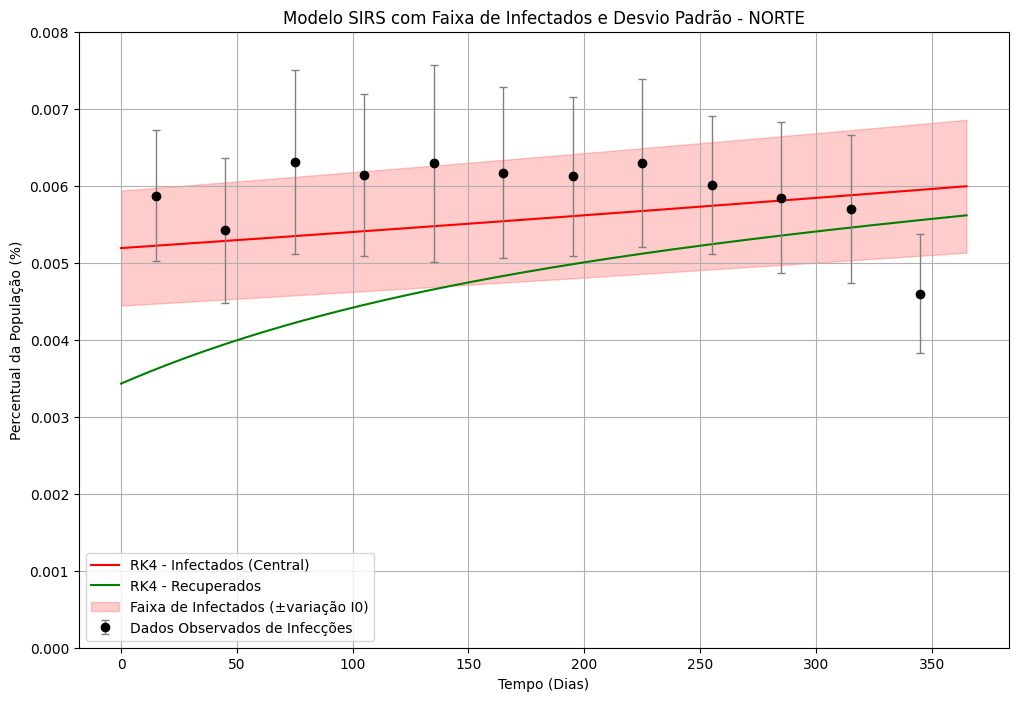

Gr√°fico salvo em: NORDESTE_SIRS_plot.png


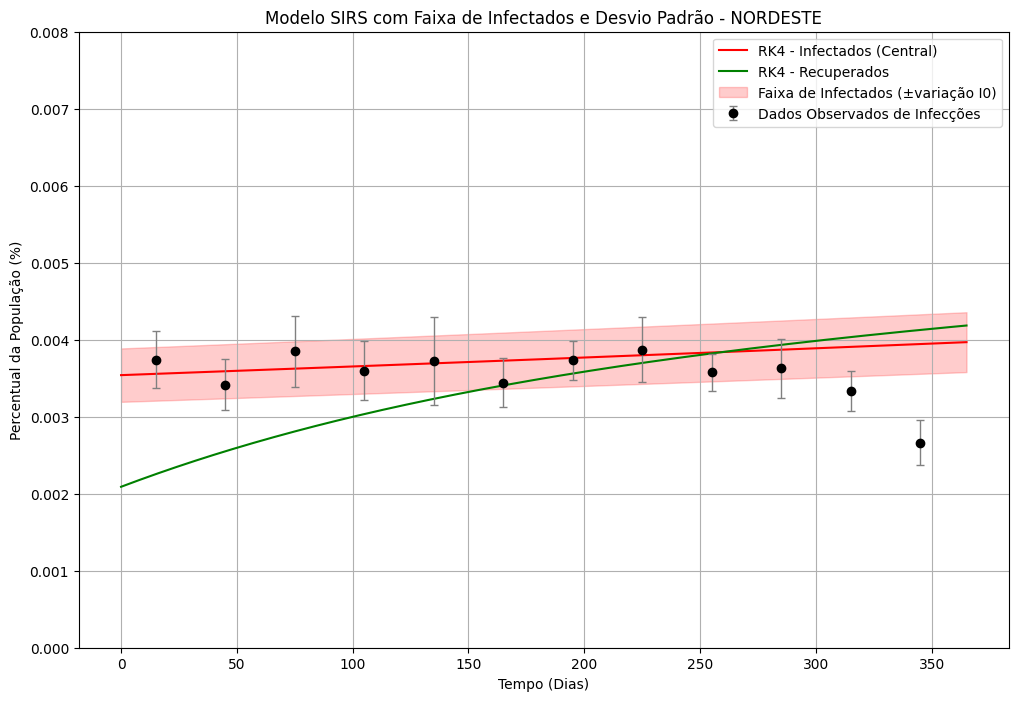

Gr√°fico salvo em: SUDESTE_SIRS_plot.png


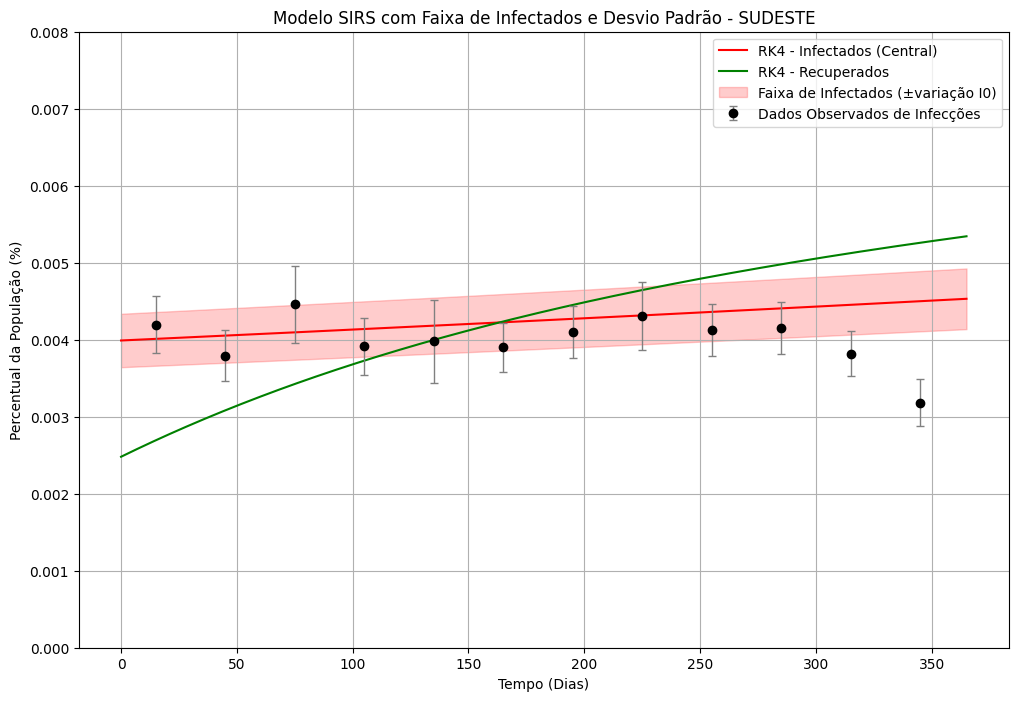

Gr√°fico salvo em: SUL_SIRS_plot.png


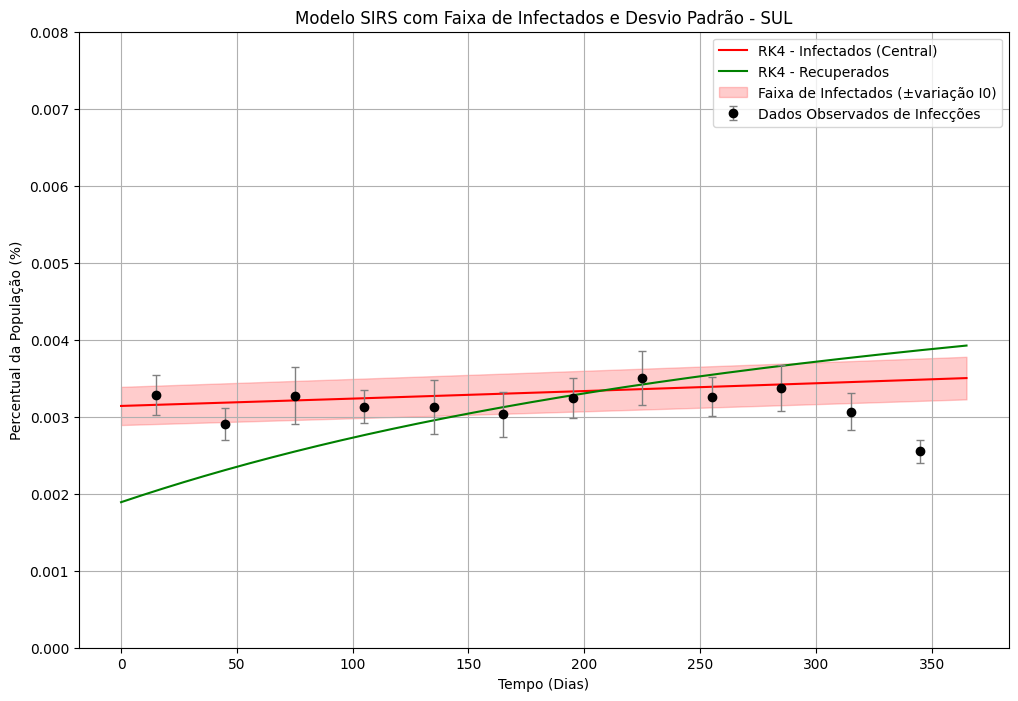

Gr√°fico salvo em: CENTROOESTE_SIRS_plot.png


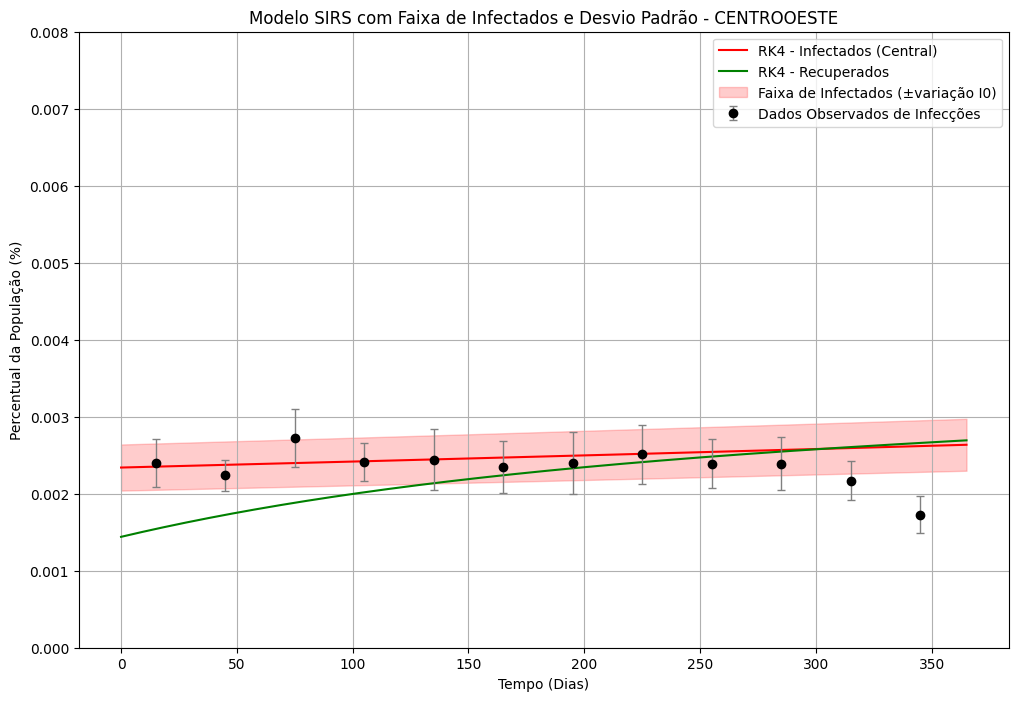

In [4]:
# Fun√ß√£o para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equa√ß√µes SIRS.
    
    Par√¢metros:
    - S: Popula√ß√£o suscet√≠vel (%)
    - I: Popula√ß√£o infectada (%)
    - R: Popula√ß√£o recuperada (%)
    - beta_f: Taxa de transmiss√£o
    - gamma_f: Taxa de recupera√ß√£o
    - mu_s: Taxa de mortalidade natural (suscet√≠veis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na popula√ß√£o
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscet√≠veis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# M√©todo de Runge-Kutta de 4¬™ Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Corre√ß√£o aqui

        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Par√¢metros de simula√ß√£o
t_max = 365  # Tempo m√°ximo de simula√ß√£o (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada regi√£o
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

# Definindo os valores de gamma para cada regi√£o
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada regi√£o
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada regi√£o
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada regi√£o
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada regi√£o
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada regi√£o
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de m√©dia de casos em percentual para cada regi√£o
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padr√£o de casos em percentual para cada regi√£o
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a varia√ß√£o de I0 para cada regi√£o (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gr√°ficos para cada regi√£o
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medi√ß√£o
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gr√°ficos para cada regi√£o com os pontos de dados observados nos dias de medi√ß√£o
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a regi√£o atual
    variacao_I0 = variacao_I0_valores[regiao]  # Varia√ß√£o de I0 para a regi√£o atual

    # Definindo dois valores de I0 para criar a faixa (¬±varia√ß√£o_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o m√©todo RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (¬±varia√ß√£o I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infec√ß√µes',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da Popula√ß√£o (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padr√£o - {regiao}')
    plt.legend()
    plt.grid(True)
    # Salvar o gr√°fico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gr√°fico salvo em: {filename}')
    
    # Exibir o gr√°fico
    plt.show()

# Calculando o valor de 'R0'(n√∫mero b√°sico de reprodu√ß√£o) de cada regi√£o

In [5]:
# Definindo a fun√ß√£o para calcular R‚ÇÄ
def calcular_R0(beta_f, gamma_f, mu_i):
    return beta_f / (gamma_f + mu_i)

# Listando as regi√µes
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']

# Par√¢metros de beta, gamma, mu_i e mu_s para cada regi√£o (j√° definidos no seu c√≥digo)
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.0060,
    'CENTROOESTE': 0.0067
}

mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.0030,
    'SUL': 0.0037,
    'CENTROOESTE': 0.0030
}

# Calculando e exibindo o R‚ÇÄ para cada regi√£o
for regiao in regioes:
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    
    R0 = calcular_R0(beta_f, gamma_f, mu_i)
    print(f"R‚ÇÄ da regi√£o {regiao}: {R0:.4f}")

R‚ÇÄ da regi√£o NORTE: 1.3970
R‚ÇÄ da regi√£o NORDESTE: 1.2551
R‚ÇÄ da regi√£o SUDESTE: 1.1980
R‚ÇÄ da regi√£o SUL: 1.1948
R‚ÇÄ da regi√£o CENTROOESTE: 1.3000


### Interpreta√ß√£o dos Resultados:

R‚ÇÄ > 1: Indica que a doen√ßa tende a se espalhar na regi√£o.

R‚ÇÄ = 1: A doen√ßa se mant√©m est√°vel na popula√ß√£o.

R‚ÇÄ < 1: A doen√ßa tende a diminuir e eventualmente desaparecer.

# Pontos de equil√≠brio triviais e n√£o-triviais

Os pontos de equil√≠brio triviais s√£o as situa√ß√µes onde a varia√ß√£o de cada compartimento √© 0, logo, n√£o h√° infectados nem recuperados, e a quantidade de suscet√≠veis se mant√©m igual √† popula√ß√£o total.

Como esta n√£o √© a situa√ß√£o real, encontramos tamb√©m os pontos de equil√≠brio n√£o-triviais, os quais dependem das taxas intr√≠nsecas da doen√ßa

In [6]:
# Fun√ß√£o para calcular R0
def calcular_R0(beta_f, gamma_f, mu_i, mu_s):
    return beta_f / (gamma_f + mu_i)

# Encontrando pontos de equil√≠brio
def ponto_equilibrio(beta_f, gamma_f, mu_s, mu_i, eta, xi):
    # Ponto de equil√≠brio trivial
    S_eq_trivial, I_eq_trivial, R_eq_trivial = 1, 0, 0
    
    # Pontos de equil√≠brio n√£o triviais
    R0 = calcular_R0(beta_f, gamma_f, mu_i, mu_s)
    
    # Equil√≠brio para S
    S_eq = 1 / R0
    # Equil√≠brio para I
    I_eq = mu_i * (R0 - 1) / beta_f
    # Equil√≠brio para R
    R_eq = 1 - S_eq - I_eq  # Total deve ser 1 (popula√ß√£o normalizada)
    
    # Normaliza√ß√£o para garantir propor√ß√£o correta da popula√ß√£o (S_eq + I_eq + R_eq = 1)
    total = S_eq + I_eq + R_eq
    S_eq /= total
    I_eq /= total       
    R_eq /= total
    
    return (S_eq_trivial, I_eq_trivial, R_eq_trivial), (S_eq, I_eq, R_eq)

# Calculando pontos de equil√≠brio para cada regi√£o
for regiao in regioes:
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]
    
    trivial, n_trivial = ponto_equilibrio(beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    print(f"Ponto de equil√≠brio trivial da regi√£o {regiao}: S = {trivial[0]:.4f}, I = {trivial[1]:.4f}, R = {trivial[2]:.4f}")
    print(f"Ponto de equil√≠brio n√£o-trivial da regi√£o {regiao}: S = {n_trivial[0]:.4f}, I = {n_trivial[1]:.4f}, R = {n_trivial[2]:.4f}")

Ponto de equil√≠brio trivial da regi√£o NORTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equil√≠brio n√£o-trivial da regi√£o NORTE: S = 0.7158, I = 0.0767, R = 0.2075
Ponto de equil√≠brio trivial da regi√£o NORDESTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equil√≠brio n√£o-trivial da regi√£o NORDESTE: S = 0.7967, I = 0.0705, R = 0.1327
Ponto de equil√≠brio trivial da regi√£o SUDESTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equil√≠brio n√£o-trivial da regi√£o SUDESTE: S = 0.8348, I = 0.0506, R = 0.1147
Ponto de equil√≠brio trivial da regi√£o SUL: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equil√≠brio n√£o-trivial da regi√£o SUL: S = 0.8369, I = 0.0622, R = 0.1009
Ponto de equil√≠brio trivial da regi√£o CENTROOESTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equil√≠brio n√£o-trivial da regi√£o CENTROOESTE: S = 0.7692, I = 0.0714, R = 0.1594


# Analise de estabilidade

Na an√°lise de estabilidade, foi tomada a Jacobiana dos compartimentos S,I,R, para que a partir dos autovalores, possa ser identificada a estabilidade (parte real negativa) ou instabilidade (parte real positiva) de cada regi√£o.

Se uma regi√£o se mostrar inst√°vel, isso mostra que, uma pequena varia√ß√£o no n√∫mero de infectados pode indicar uma nova potencial epidemia naquela regi√£o, visto que os valores ir√£o se afastar do ponto de estabilidade, o qual representa a situa√ß√£o de infectados e recuperados linear, caracter√≠stico da tuberculose.

Se uma regi√£o se mostrar est√°vel, isso mostra que mesmo com varia√ß√µes no n√∫mero de infectados, a chance de se ocorrer uma epidemia √© baixa, visto que o sistema ir√° tender a se aproximar no ponto de estabilidade novamente.

In [7]:
# Fun√ß√£o para calcular a Jacobiana no ponto de equil√≠brio
def jacobiana(S_eq, I_eq, R_eq, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    # Derivadas parciais das equa√ß√µes do sistema SIRS
    J = np.array([
        [-(beta_f * I_eq) + (eta - mu_s), -(beta_f * S_eq), xi],
        [beta_f * I_eq, (beta_f * S_eq) - (gamma_f + mu_i), 0],
        [0, gamma_f, -xi]
    ])
    return J

# Fun√ß√£o para verificar a estabilidade
def verificar_estabilidade(beta_f, gamma_f, mu_s, mu_i, eta, xi):
    # Calcula os pontos de equil√≠brio
    trivial, n_trivial = ponto_equilibrio(beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Calcula a Jacobiana no ponto de equil√≠brio n√£o trivial
    S_eq, I_eq, R_eq = n_trivial
    J = jacobiana(S_eq, I_eq, R_eq, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Calcula os autovalores da matriz Jacobiana
    autovalores = np.linalg.eigvals(J)
    
    # Verifica se todos os autovalores t√™m parte real negativa (condi√ß√£o de estabilidade)
    if all(np.real(autoval) < 0 for autoval in autovalores):
        return "Est√°vel", autovalores
    else:
        return "Inst√°vel", autovalores

# Testando a fun√ß√£o para cada regi√£o
for regiao in regioes:
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]

    estabilidade, autovalores = verificar_estabilidade(beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    print(f"Regi√£o {regiao}: {estabilidade}")
    print(f"Autovalores: {autovalores}")

Regi√£o NORTE: Inst√°vel
Autovalores: [ 0.00062476+0.00201599j  0.00062476-0.00201599j -0.00237141+0.j        ]
Regi√£o NORDESTE: Inst√°vel
Autovalores: [ 9.05825249e-05+0.00214439j  9.05825249e-05-0.00214439j
 -2.04851199e-03+0.j        ]
Regi√£o SUDESTE: Inst√°vel
Autovalores: [ 1.88997902e-05+0.00157821j  1.88997902e-05-0.00157821j
 -2.43167713e-03+0.j        ]
Regi√£o SUL: Est√°vel
Autovalores: [-7.49968954e-05+0.00201359j -7.49968954e-05-0.00201359j
 -1.97093404e-03+0.j        ]
Regi√£o CENTROOESTE: Inst√°vel
Autovalores: [ 0.00026052+0.00202443j  0.00026052-0.00202443j -0.00217104+0.j        ]


# Calculando o beta_intrinseco da TB

In [8]:
# Dados fornecidos
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

SEIDH_valores = {
    'NORTE': 0.71,
    'NORDESTE': 0.69,
    'SUDESTE': 0.78,
    'SUL': 0.79,
    'CENTROOESTE': 0.77
}

dp_valores = {
    'NORTE': 4.51,
    'NORDESTE': 35.21,
    'SUDESTE': 91.76,
    'SUL': 51.91,
    'CENTROOESTE': 10.14
}

# Fun√ß√£o para normalizar DP usando DP_max
def normalizar_dp_dpmax(dp_dict):
    dp_max = max(dp_dict.values())
    f_dp = {}
    for regiao, dp in dp_dict.items():
        if dp_max != 0:
            f_dp[regiao] = dp / dp_max
        else:
            f_dp[regiao] = 0  # Evita divis√£o por zero
    return f_dp, dp_max

# Calcular f(DP) para cada regi√£o e obter DP_max
f_dp, dp_max = normalizar_dp_dpmax(dp_valores)

# C√°lculo do beta intr√≠nseco usando a f√≥rmula ajustada
beta_intrinseco = {}

for regiao in beta_valores:
    beta = beta_valores[regiao]           # Beta observado
    SEIDH = SEIDH_valores[regiao]         # √çndice de Desenvolvimento Humano
    DP = dp_valores[regiao]               # Densidade demogr√°fica
    
    # Calcular f(DP) = DP / DP_max
    f_DP = f_dp[regiao]
    
    # Aplicar a f√≥rmula ajustada
    beta_int = beta * (1 + f_DP) / (1 + SEIDH)
    
    beta_intrinseco[regiao] = beta_int

# C√°lculo das diferen√ßas entre beta_valores e beta_intrinseco
diferenca_betas = {}

for regiao in beta_valores:
    diferenca = beta_valores[regiao] - beta_intrinseco[regiao]
    diferenca_betas[regiao] = diferenca

# Exibindo os resultados
print("Resultados do c√°lculo do Beta Intr√≠nseco e Diferen√ßas:\n")
print(f"{'Regi√£o':<15}{'Œ≤_valores':<15}{'Œ≤_intr√≠nseco':<20}{'Diferen√ßa':<15}")
print("-" * 65)
for regiao in beta_valores:
    print(f"{regiao:<15}{beta_valores[regiao]:<15.6f}{beta_intrinseco[regiao]:<20.6f}{diferenca_betas[regiao]:<15.6f}")

Resultados do c√°lculo do Beta Intr√≠nseco e Diferen√ßas:

Regi√£o         Œ≤_valores      Œ≤_intr√≠nseco        Diferen√ßa      
-----------------------------------------------------------------
NORTE          0.013970       0.008571            0.005399       
NORDESTE       0.012300       0.010071            0.002229       
SUDESTE        0.011740       0.013191            -0.001451      
SUL            0.011590       0.010138            0.001452       
CENTROOESTE    0.012610       0.007912            0.004698       


## Observa√ß√µes:

NORTE:

DP Normalizado: 0.0492 (Baixa densidade demogr√°fica)
SEIDH: 0.71 (Moderadamente alto)
Œ≤_intr√≠nseco: 0.008571 (menor que Œ≤_valores)
Diferen√ßa: 0.005379
NORDESTE:

DP Normalizado: 0.3832 (Moderada densidade demogr√°fica)
SEIDH: 0.69 (Moderadamente alto)
Œ≤_intr√≠nseco: 0.010080 (menor que Œ≤_valores)
Diferen√ßa: 0.002220
SUDESTE:

DP Normalizado: 1.0 (Maior densidade demogr√°fica)
SEIDH: 0.78 (Alto)
Œ≤_intr√≠nseco: 0.013180 (maior que Œ≤_valores)
Diferen√ßa: -0.001440
SUL:

DP Normalizado: 0.5663 (Alta densidade demogr√°fica)
SEIDH: 0.79 (Alto)
Œ≤_intr√≠nseco: 0.010150 (menor que Œ≤_valores)
Diferen√ßa: 0.001450
CENTROOESTE:

DP Normalizado: 0.1105 (Moderadamente baixa densidade demogr√°fica)
SEIDH: 0.77 (Alto)
Œ≤_intr√≠nseco: 0.007900 (menor que Œ≤_valores)
Diferen√ßa: 0.004720

## An√°lise dos Resultados:
Consist√™ncia com a L√≥gica Epidemiol√≥gica:

Maior DP: Regi√µes com maior densidade demogr√°fica (como SUDESTE) deveriam ter maior Œ≤_valores, o que ocorreu, exceto que SUDESTE apresentou Œ≤_valores ligeiramente menores que Œ≤_intrinseco devido ao alto SEIDH.
Maior SEIDH: Regi√µes com maior SEIDH (como SUDESTE e SUL) t√™m Œ≤_valores reduzido ou ligeiramente aumentado, dependendo da rela√ß√£o com DP.

Diferen√ßas M√≠nimas:

A maioria das diferen√ßas entre Œ≤_valores e Œ≤_intr√≠nseco s√£o pequenas (entre ~0.001 a ~0.005), mantendo-os na mesma ordem de magnitude, conforme esperado.

Exce√ß√£o: SUDESTE

SUDESTE: Apesar de ter a maior densidade demogr√°fica, seu alto SEIDH resulta em um Œ≤_valores ligeiramente menor que Œ≤_intrinseco. Isso pode ocorrer devido √† rela√ß√£o proporcional na f√≥rmula, onde (1 + f(DP)) aumenta Œ≤_valores, mas (1 + SEIDH) tamb√©m aumenta, por√©m menos proporcionalmente. O que pode indicar que o fator do IDH est√° diminuindo o Œ≤_valores

In [9]:
dados = {
    "Regi√£o": ["NORTE", "NORDESTE", "SUDESTE", "SUL", "CENTROOESTE"],
    "Œ≤_valores": [0.013970, 0.012300, 0.011740, 0.011590, 0.012610],
    "Œ≤_intr√≠nseco": [0.008571, 0.010071, 0.013191, 0.010138, 0.007912]
}

# Calcular a m√©dia e desvio padr√£o para Œ≤_valores
media_valores = np.mean(dados["Œ≤_valores"])
desvio_valores = np.std(dados["Œ≤_valores"], ddof=1)

# Calcular a m√©dia e desvio padr√£o para Œ≤_intr√≠nseco
media_intrinseco = np.mean(dados["Œ≤_intr√≠nseco"])
desvio_intrinseco = np.std(dados["Œ≤_intr√≠nseco"], ddof=1)

# Exibir os resultados
print(f"M√©dia de Œ≤_valores: {media_valores:.6f}")
print(f"Desvio padr√£o de Œ≤_valores: {desvio_valores:.6f}")
print(f"M√©dia de Œ≤_intr√≠nseco: {media_intrinseco:.6f}")
print(f"Desvio padr√£o de Œ≤_intr√≠nseco: {desvio_intrinseco:.6f}")

M√©dia de Œ≤_valores: 0.012442
Desvio padr√£o de Œ≤_valores: 0.000949
M√©dia de Œ≤_intr√≠nseco: 0.009977
Desvio padr√£o de Œ≤_intr√≠nseco: 0.002037


# C√≥digo bonus: balanceando a influencia de DP e SEIDH no modelo

In [10]:
# Defini√ß√£o dos coeficientes a serem testados
alpha_values = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 1, 1, 1]  # Coeficientes para f(DP)
beta_coef_values = [0.1, 0.5, 1, 0.1, 0.5, 1, 0.1, 0.5, 1,]  # Coeficientes para SEIDH

# Dicion√°rio para armazenar os resultados de cada combina√ß√£o
resultados_teste = []

# Loop para cada combina√ß√£o de alpha e beta_coef
for i in range(len(alpha_values)):
    alpha = alpha_values[i]
    beta_coef = beta_coef_values[i]
    
    # C√°lculo do beta intr√≠nseco ajustado
    beta_intrinseco_adjusted = {}
    for regiao in beta_valores:
        beta = beta_valores[regiao]           # Beta observado
        SEIDH = SEIDH_valores[regiao]         # √çndice de Desenvolvimento Humano
        DP = dp_valores[regiao]               # Densidade demogr√°fica
        
        # Calcular f(DP) = DP / DP_max
        f_DP = f_dp[regiao]
        
        # Aplicar a f√≥rmula ajustada com coeficientes
        beta_int = beta * (1 + alpha * f_DP) / (1 + beta_coef * SEIDH)
        beta_intrinseco_adjusted[regiao] = beta_int

    # C√°lculo das diferen√ßas entre beta_valores e beta_intrinseco_adjusted
    diferenca_betas_adjusted = {}
    for regiao in beta_valores:
        diferenca = beta_valores[regiao] - beta_intrinseco_adjusted[regiao]
        diferenca_betas_adjusted[regiao] = diferenca
    
    # Armazenando o resultado da combina√ß√£o atual
    resultados_teste.append({
        'alpha': alpha,
        'beta_coef': beta_coef,
        'beta_intrinseco_adjusted': beta_intrinseco_adjusted,
        'diferenca_betas_adjusted': diferenca_betas_adjusted
    })

# Exibindo os resultados de cada combina√ß√£o
for resultado in resultados_teste:
    print(f"\nResultados para alpha = {resultado['alpha']} e beta_coef = {resultado['beta_coef']}:\n")
    print(f"{'Regi√£o':<15}{'Œ≤_valores':<15}{'Œ≤_intr√≠nseco':<20}{'Diferen√ßa':<15}")
    print("-" * 65)
    for regiao in beta_valores:
        print(f"{regiao:<15}{beta_valores[regiao]:<15.6f}{resultado['beta_intrinseco_adjusted'][regiao]:<20.6f}{resultado['diferenca_betas_adjusted'][regiao]:<15.6f}")


Resultados para alpha = 0.1 e beta_coef = 0.1:

Regi√£o         Œ≤_valores      Œ≤_intr√≠nseco        Diferen√ßa      
-----------------------------------------------------------------
NORTE          0.013970       0.013108            0.000862       
NORDESTE       0.012300       0.011948            0.000352       
SUDESTE        0.011740       0.011980            -0.000240      
SUL            0.011590       0.011349            0.000241       
CENTROOESTE    0.012610       0.011838            0.000772       

Resultados para alpha = 0.1 e beta_coef = 0.5:

Regi√£o         Œ≤_valores      Œ≤_intr√≠nseco        Diferen√ßa      
-----------------------------------------------------------------
NORTE          0.013970       0.010361            0.003609       
NORDESTE       0.012300       0.009496            0.002804       
SUDESTE        0.011740       0.009291            0.002449       
SUL            0.011590       0.008778            0.002812       
CENTROOESTE    0.012610       0.00

## OBS:

Œ± e ùõΩ: Ajuste esses valores para calibrar a influ√™ncia relativa de DP e SEIDH. 

Por exemplo, se desejar que DP tenha menos influ√™ncia, defina ùõº < 1.
Caso contrario defina que ùõΩ < 1.

## Talvez o desvio padr√£o ajude a decidir os valores de alpha e beta nesse caso

# Calculando o Gamma_intrinseco da TB

In [11]:
# Dados fornecidos
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.0060,
    'CENTROOESTE': 0.0067
}

SASUS_valores = {
    'NORTE': 0.1775,
    'NORDESTE': 0.198,
    'SUDESTE': 0.20675,
    'SUL': 0.23175,
    'CENTROOESTE': 0.21775
}

# Fun√ß√£o para calcular gamma_intrinseco
def calcular_gamma_intrinseco(gamma_valores, SASUS_valores):
    gamma_intrinseco = {}
    for regiao in gamma_valores:
        gamma = gamma_valores[regiao]
        SASUS = SASUS_valores[regiao]
        # Aplicar a f√≥rmula: gamma_intrinseco = gamma_valores / (1 + SASUS)
        gamma_int = gamma / (1 + SASUS)
        gamma_intrinseco[regiao] = gamma_int
    return gamma_intrinseco

# Fun√ß√£o para calcular a diferen√ßa entre gamma_valores e gamma_intrinseco
def calcular_diferenca_gamma(gamma_valores, gamma_intrinseco):
    diferenca = {}
    for regiao in gamma_valores:
        diferenca_regiao = gamma_valores[regiao] - gamma_intrinseco[regiao]
        diferenca[regiao] = diferenca_regiao
    return diferenca

# Fun√ß√£o para calcular m√©dia e desvio padr√£o
def calcular_estatisticas(dicionario, nome):
    valores = list(dicionario.values())
    media = statistics.mean(valores)
    # Se houver apenas um elemento, stdev levantar√° um erro. Garantir que h√° pelo menos dois.
    if len(valores) > 1:
        desvio_padrao = statistics.stdev(valores)
    else:
        desvio_padrao = 0.0
    print(f"{nome}:")
    print(f"  M√©dia: {media:.6f}")
    print(f"  Desvio Padr√£o: {desvio_padrao:.6f}\n")

# Calcular gamma_intrinseco
gamma_intrinseco = calcular_gamma_intrinseco(gamma_valores, SASUS_valores)

# Calcular a diferen√ßa
diferenca_gamma = calcular_diferenca_gamma(gamma_valores, gamma_intrinseco)

# Exibir os resultados de gamma_intrinseco e diferen√ßas
print("Resultados do c√°lculo do Gamma Intr√≠nseco e Diferen√ßas:\n")
print(f"{'Regi√£o':<15}{'Œ≥_valores':<15}{'Œ≥_intr√≠nseco':<20}{'Diferen√ßa':<15}")
print("-" * 65)
for regiao in gamma_valores:
    print(f"{regiao:<15}{gamma_valores[regiao]:<15.6f}{gamma_intrinseco[regiao]:<20.6f}{diferenca_gamma[regiao]:<15.6f}")

# Calcular e exibir estat√≠sticas
print("\nEstat√≠sticas:\n")
calcular_estatisticas(gamma_valores, "Gamma Valores")
calcular_estatisticas(gamma_intrinseco, "Gamma Intr√≠nseco")

Resultados do c√°lculo do Gamma Intr√≠nseco e Diferen√ßas:

Regi√£o         Œ≥_valores      Œ≥_intr√≠nseco        Diferen√ßa      
-----------------------------------------------------------------
NORTE          0.007300       0.006200            0.001100       
NORDESTE       0.006400       0.005342            0.001058       
SUDESTE        0.006800       0.005635            0.001165       
SUL            0.006000       0.004871            0.001129       
CENTROOESTE    0.006700       0.005502            0.001198       

Estat√≠sticas:

Gamma Valores:
  M√©dia: 0.006640
  Desvio Padr√£o: 0.000483

Gamma Intr√≠nseco:
  M√©dia: 0.005510
  Desvio Padr√£o: 0.000482



# Erro, acur√°cia e precis√£o

Para avaliar o desempenho do seu modelo SIRS para cada regi√£o, podemos calcular m√©tricas de erro comparando as previs√µes do modelo com os dados observados. Isso nos permitir√° avaliar o erro, a acur√°cia e a precis√£o do modelo.

Passos para calcular as m√©tricas:

Interpolar as previs√µes do modelo nos dias de medi√ß√£o: Como o modelo produz resultados di√°rios, precisamos extrair os valores de infectados (I_rk4) nos dias correspondentes aos dias_medicao.

Calcular as diferen√ßas entre as previs√µes e os dados observados: Para cada dia de medi√ß√£o, calculamos a diferen√ßa entre o valor previsto pelo modelo e o valor observado.

Calcular as m√©tricas de erro:

Erro M√©dio Absoluto (MAE): M√©dia das diferen√ßas absolutas entre previs√µes e observa√ß√µes.

Erro Quadr√°tico M√©dio (MSE): M√©dia dos quadrados das diferen√ßas entre previs√µes e observa√ß√µes.
m
Raiz do Erro Quadr√°tico M√©dio (RMSE): Raiz quadrada do MSE.

Acur√°cia: Podemos considerar a acur√°cia como a capacidade do modelo em produzir previs√µes pr√≥ximas aos dados observados.

Precis√£o: Refere-se √† consist√™ncia das previs√µes do modelo. Um modelo √© preciso se produz resultados semelhantes em m√∫ltiplas execu√ß√µes ou sob varia√ß√µes dos par√¢metros iniciais.

Regi√£o: NORTE
Erro M√©dio Absoluto (MAE): 0.000575
Erro Quadr√°tico M√©dio (MSE): 0.000000
Raiz do Erro Quadr√°tico M√©dio (RMSE): 0.000680
Erro M√©dio Percentual Absoluto (MAPE): 9.99%

Gr√°fico salvo em: NORTE_SIRS_plot.png


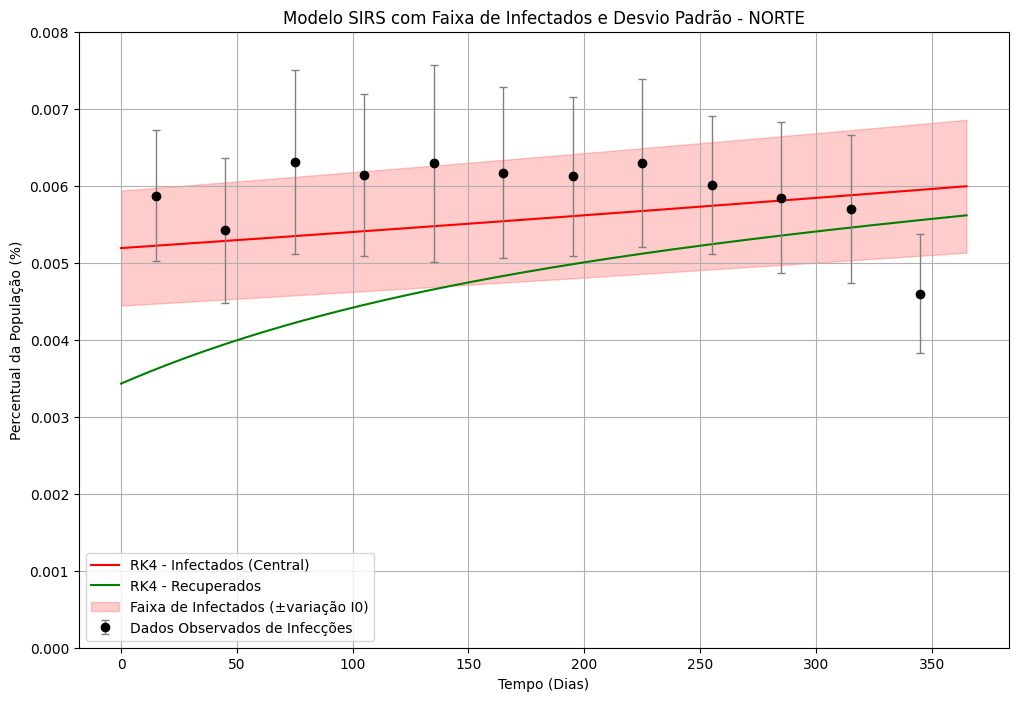

Regi√£o: NORDESTE
Erro M√©dio Absoluto (MAE): 0.000285
Erro Quadr√°tico M√©dio (MSE): 0.000000
Raiz do Erro Quadr√°tico M√©dio (RMSE): 0.000438
Erro M√©dio Percentual Absoluto (MAPE): 9.05%

Gr√°fico salvo em: NORDESTE_SIRS_plot.png


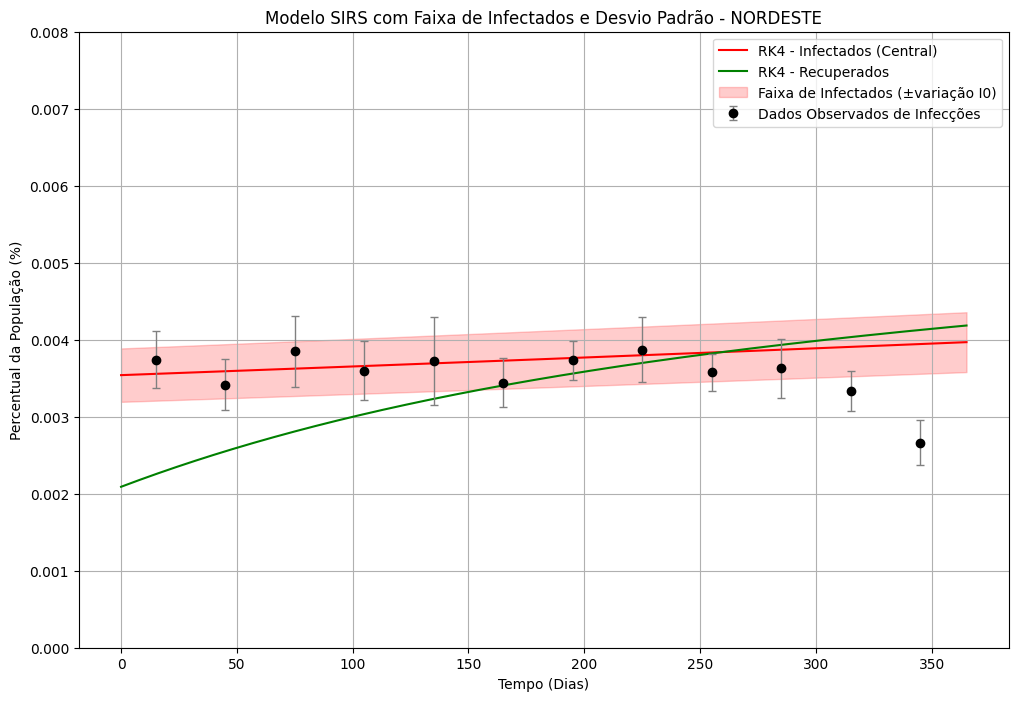

Regi√£o: SUDESTE
Erro M√©dio Absoluto (MAE): 0.000349
Erro Quadr√°tico M√©dio (MSE): 0.000000
Raiz do Erro Quadr√°tico M√©dio (RMSE): 0.000476
Erro M√©dio Percentual Absoluto (MAPE): 9.40%

Gr√°fico salvo em: SUDESTE_SIRS_plot.png


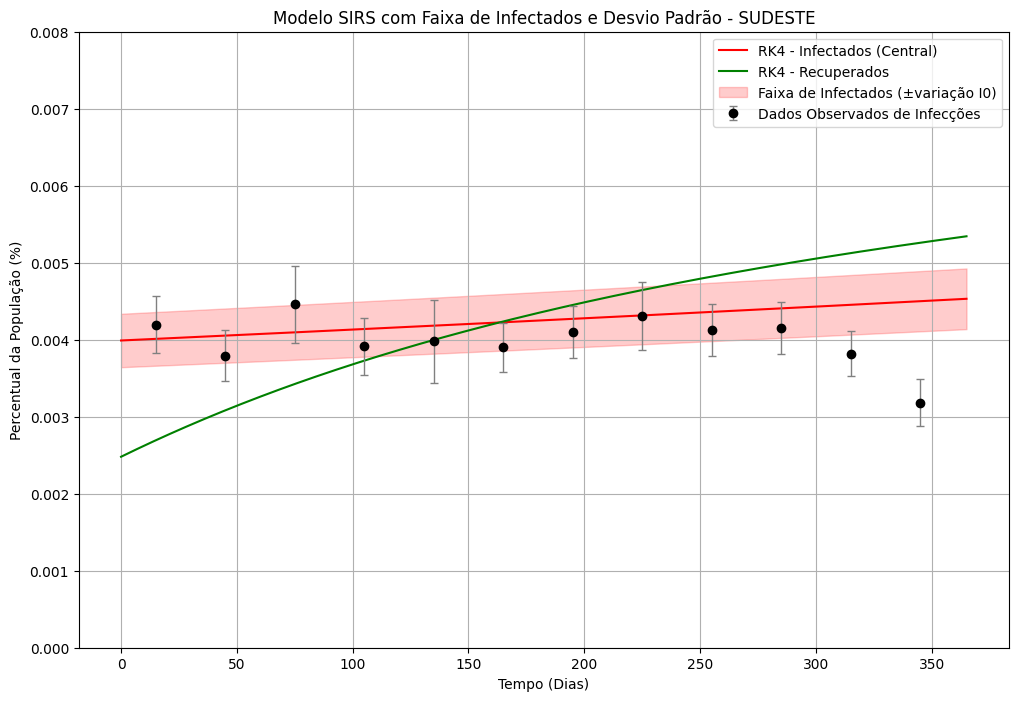

Regi√£o: SUL
Erro M√©dio Absoluto (MAE): 0.000225
Erro Quadr√°tico M√©dio (MSE): 0.000000
Raiz do Erro Quadr√°tico M√©dio (RMSE): 0.000323
Erro M√©dio Percentual Absoluto (MAPE): 7.76%

Gr√°fico salvo em: SUL_SIRS_plot.png


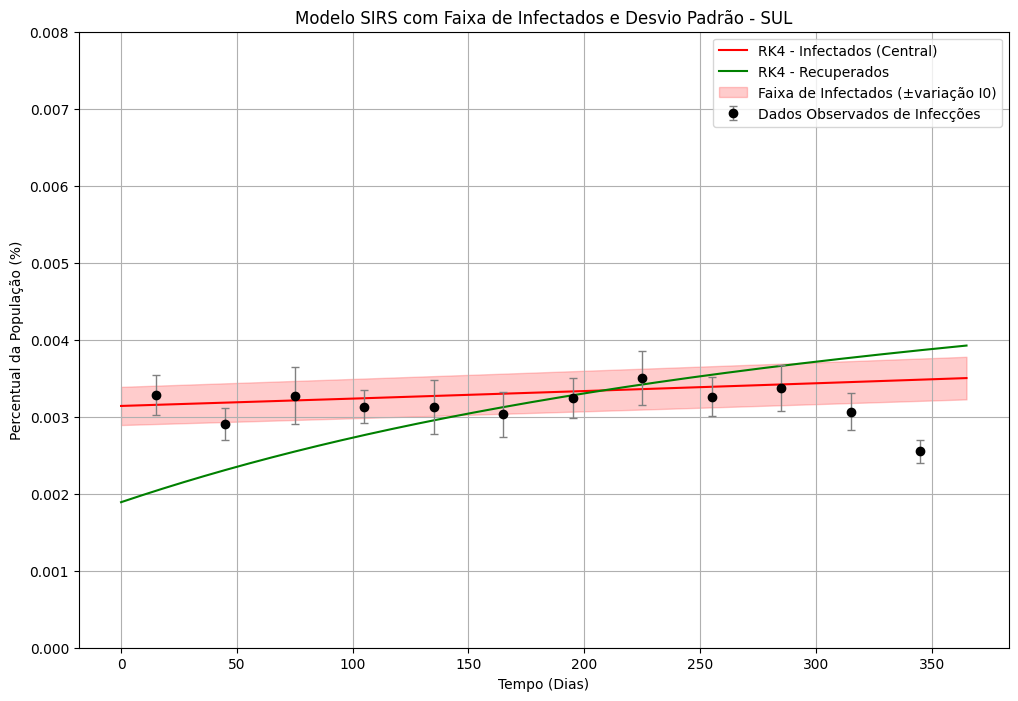

Regi√£o: CENTROOESTE
Erro M√©dio Absoluto (MAE): 0.000199
Erro Quadr√°tico M√©dio (MSE): 0.000000
Raiz do Erro Quadr√°tico M√©dio (RMSE): 0.000313
Erro M√©dio Percentual Absoluto (MAPE): 9.55%

Gr√°fico salvo em: CENTROOESTE_SIRS_plot.png


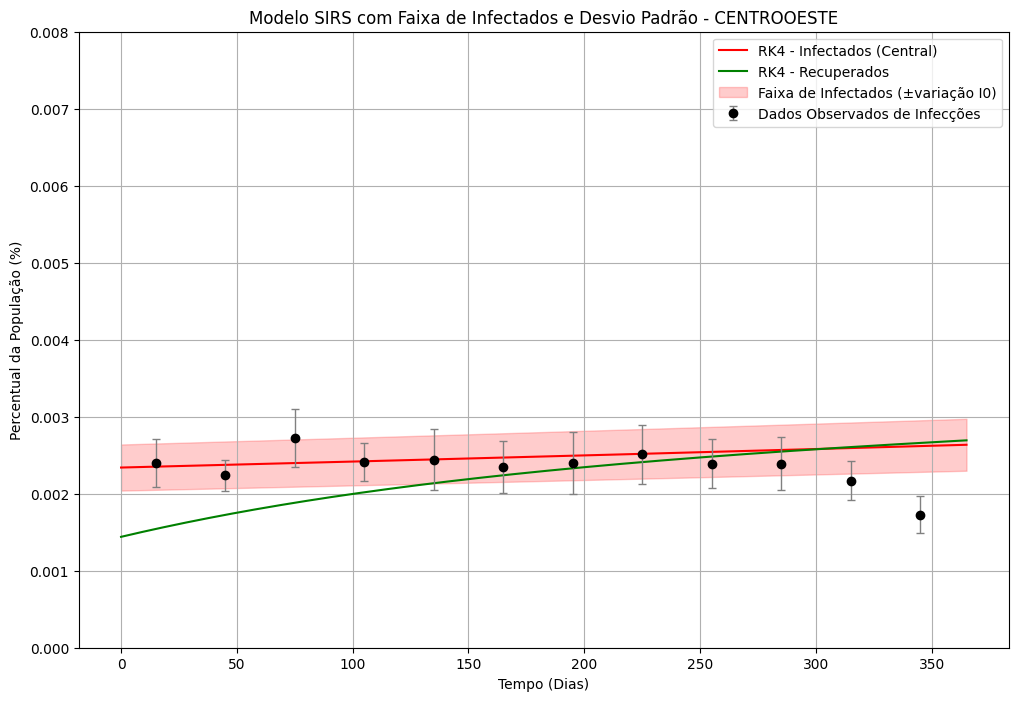

In [12]:
# Criando gr√°ficos para cada regi√£o com os pontos de dados observados nos dias de medi√ß√£o
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a regi√£o atual
    variacao_I0 = variacao_I0_valores[regiao]  # Varia√ß√£o de I0 para a regi√£o atual

    # Definindo dois valores de I0 para criar a faixa (¬±varia√ß√£o_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o m√©todo RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(
        S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Executando o m√©todo RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(
        S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Executando o m√©todo RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(
        S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # --- Aqui come√ßa a inclus√£o das m√©tricas de erro ---

    # Interpolando os valores de I_rk4 nos dias de medi√ß√£o
    I_modelo_medicao = [I_rk4[int(dia / dt)] for dia in dias_medicao]

    # Convertendo listas em arrays numpy para facilitar os c√°lculos
    I_modelo_medicao = np.array(I_modelo_medicao)
    I_observado = np.array(media_casos_percentual[regiao])

    # Calculando o MAE
    mae = mean_absolute_error(I_observado, I_modelo_medicao)

    # Calculando o MSE
    mse = mean_squared_error(I_observado, I_modelo_medicao)

    # Calculando o RMSE
    rmse = np.sqrt(mse)

    # Calculando o Erro M√©dio Percentual Absoluto (MAPE)
    mape = np.mean(np.abs((I_observado - I_modelo_medicao) / I_observado)) * 100

    # Exibindo as m√©tricas
    print(f'Regi√£o: {regiao}')
    print(f'Erro M√©dio Absoluto (MAE): {mae:.6f}')
    print(f'Erro Quadr√°tico M√©dio (MSE): {mse:.6f}')
    print(f'Raiz do Erro Quadr√°tico M√©dio (RMSE): {rmse:.6f}')
    print(f'Erro M√©dio Percentual Absoluto (MAPE): {mape:.2f}%\n')

    # --- Fim das m√©tricas de erro ---

    # (Restante do c√≥digo para plotar os gr√°ficos)
    # Plotando os resultados
    plt.figure(figsize=(12, 8))

    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')

    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high,
                     color='red', alpha=0.2, label='Faixa de Infectados (¬±varia√ß√£o I0)')

    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao,
        media_casos_percentual[regiao],
        yerr=desvio_padrao_casos_percentual[regiao],
        fmt='o',
        color='black',
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        label='Dados Observados de Infec√ß√µes',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)

    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da Popula√ß√£o (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padr√£o - {regiao}')
    plt.legend()
    plt.grid(True)
    # Salvar o gr√°fico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gr√°fico salvo em: {filename}')

    # Exibir o gr√°fico
    plt.show()

Interpretando os resultados:

Erro M√©dio Absoluto (MAE): Indica, em m√©dia, o quanto as previs√µes do modelo diferem dos dados observados. Valores menores indicam melhor desempenho.

Erro Quadr√°tico M√©dio (MSE) e Raiz do Erro Quadr√°tico M√©dio (RMSE): MSE penaliza erros maiores de forma mais intensa devido ao quadrado das diferen√ßas. O RMSE traz o erro para as mesmas unidades das observa√ß√µes, facilitando a interpreta√ß√£o.

Erro M√©dio Percentual Absoluto (MAPE): Expressa o erro como uma porcentagem dos valores observados, permitindo avaliar o desempenho relativo do modelo.

Acur√°cia e Precis√£o:

Acur√°cia: Se os erros (MAE, MSE, RMSE) s√£o baixos, podemos dizer que o modelo √© acurado, ou seja, ele consegue prever valores pr√≥ximos aos observados.

Precis√£o: Se ao variar os par√¢metros iniciais (como a varia√ß√£o de I0 que voc√™ j√° implementou), o modelo apresenta pequenas varia√ß√µes nas previs√µes, ele √© considerado preciso. A faixa de infectados que voc√™ plotou no gr√°fico j√° d√° uma ideia da precis√£o do modelo.

Erro M√©dio Absoluto (MAE):

Representa a m√©dia das diferen√ßas absolutas entre os valores previstos pelo modelo e os valores observados nos dados.
Valores menores de MAE indicam que as previs√µes do modelo est√£o mais pr√≥ximas dos dados reais.
No seu caso, o MAE varia de aproximadamente 0.000199 (Centro-Oeste) a 0.000575 (Norte).
Erro Quadr√°tico M√©dio (MSE) e Raiz do Erro Quadr√°tico M√©dio (RMSE):

O MSE √© a m√©dia dos quadrados das diferen√ßas entre previs√µes e observa√ß√µes. O RMSE √© a raiz quadrada do MSE.
Eles penalizam erros maiores de forma mais intensa devido ao quadrado das diferen√ßas.
Valores menores indicam melhor desempenho do modelo.
Os valores de RMSE seguem a mesma tend√™ncia do MAE.
Erro M√©dio Percentual Absoluto (MAPE):

Indica o erro m√©dio em termos percentuais, facilitando a interpreta√ß√£o relativa do erro.
No seu caso, o MAPE varia de aproximadamente 7.76% (Sul) a 9.99% (Norte).
Um MAPE de 9.99% significa que, em m√©dia, as previs√µes do modelo para a regi√£o Norte diferem dos dados reais em cerca de 9.99%.
Interpreta√ß√£o para cada regi√£o:

Norte:

MAE mais alto (0.000575) e MAPE mais alto (9.99%).
Isso indica que, comparativamente, o modelo teve um desempenho menos preciso nesta regi√£o.
Poss√≠veis raz√µes podem incluir variabilidades n√£o capturadas pelo modelo ou par√¢metros que precisam ser ajustados.
Nordeste:

MAE e MAPE ligeiramente menores que o Norte.
O modelo se ajusta um pouco melhor aqui, mas ainda h√° espa√ßo para melhorias.
Sudeste:

Valores intermedi√°rios de erro.
O desempenho do modelo √© razo√°vel, mas pode ser aprimorado com ajustes nos par√¢metros ou incluindo outros fatores relevantes.
Sul:

MAE e MAPE mais baixos entre todas as regi√µes (MAE: 0.000225, MAPE: 7.76%).
Indica que o modelo est√° representando os dados desta regi√£o com maior precis√£o.
O menor erro percentual sugere que os par√¢metros do modelo est√£o bem ajustados para esta regi√£o ou que a din√¢mica da doen√ßa √© mais consistente com as suposi√ß√µes do modelo.
Centro-Oeste:

MAE mais baixo (0.000199) e MAPE relativamente baixo (9.55%).
Embora o MAPE seja um pouco mais alto que o do Sul, o MAE √© o menor entre todas as regi√µes.
Isso sugere que, em termos absolutos, o modelo est√° prevendo muito bem nesta regi√£o.
Considera√ß√µes Gerais:

Compara√ß√£o entre Regi√µes:

O modelo apresenta melhor desempenho nas regi√µes Sul e Centro-Oeste, indicando que ele est√° mais bem calibrado ou que as caracter√≠sticas epidemiol√≥gicas dessas regi√µes s√£o melhor capturadas pelo modelo.
Nas regi√µes Norte, Nordeste e Sudeste, o modelo tem erros ligeiramente maiores, sugerindo a necessidade de refinamento.
Valores de Erro:

MAE e RMSE baixos: Os valores s√£o inferiores a 0.001, o que indica que, em termos absolutos, o erro √© pequeno.
MAPE entre 7% e 10%: Isso significa que, em m√©dia, as previs√µes do modelo est√£o dentro de 7% a 10% dos valores observados, o que √© aceit√°vel em muitos contextos epidemiol√≥gicos.
Interpreta√ß√£o do MAPE:

Um MAPE abaixo de 10% √© geralmente considerado bom em modelos preditivos.
No entanto, para epidemiologia, onde pequenas diferen√ßas podem significar grandes impactos na sa√∫de p√∫blica, pode ser desej√°vel reduzir ainda mais esse erro.

Desempenho Geral:

O modelo SIRS aplicado apresenta um desempenho razo√°vel, com erros m√©dios percentuais absolutos entre 7.76% e 9.99%.
Isso indica que o modelo est√° capturando a tend√™ncia geral da propaga√ß√£o da doen√ßa em cada regi√£o.

# Usando beta_intrinseco no lugar do beta no modelo SIRS

Gr√°fico salvo em: NORTE_SIRS_beta_intrinseco_plot.png


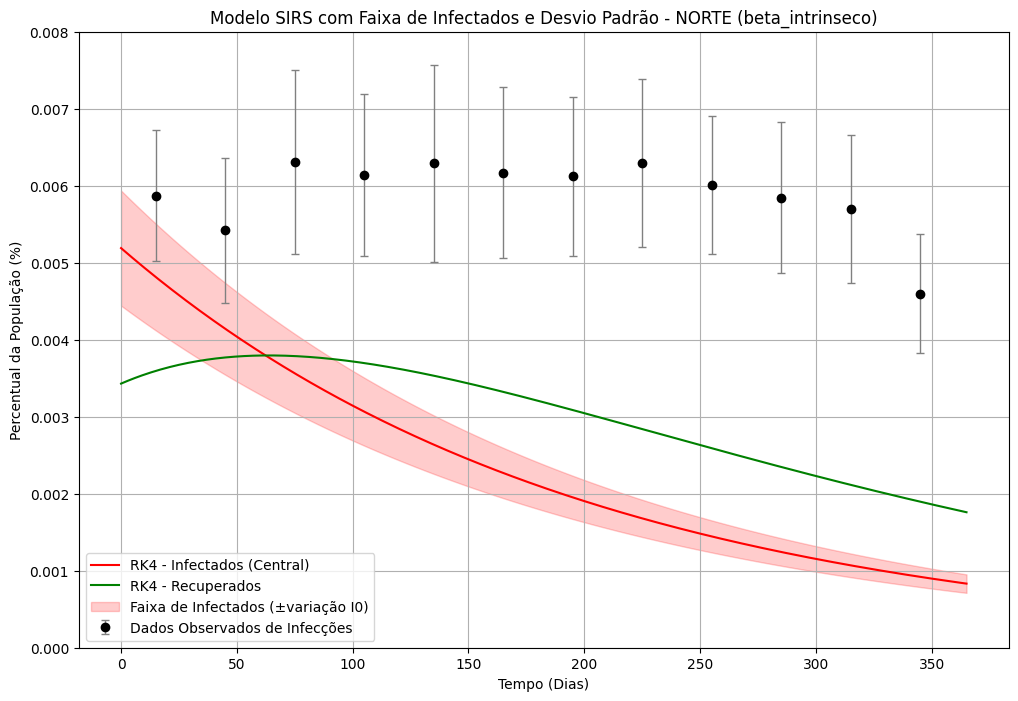

Gr√°fico salvo em: NORDESTE_SIRS_beta_intrinseco_plot.png


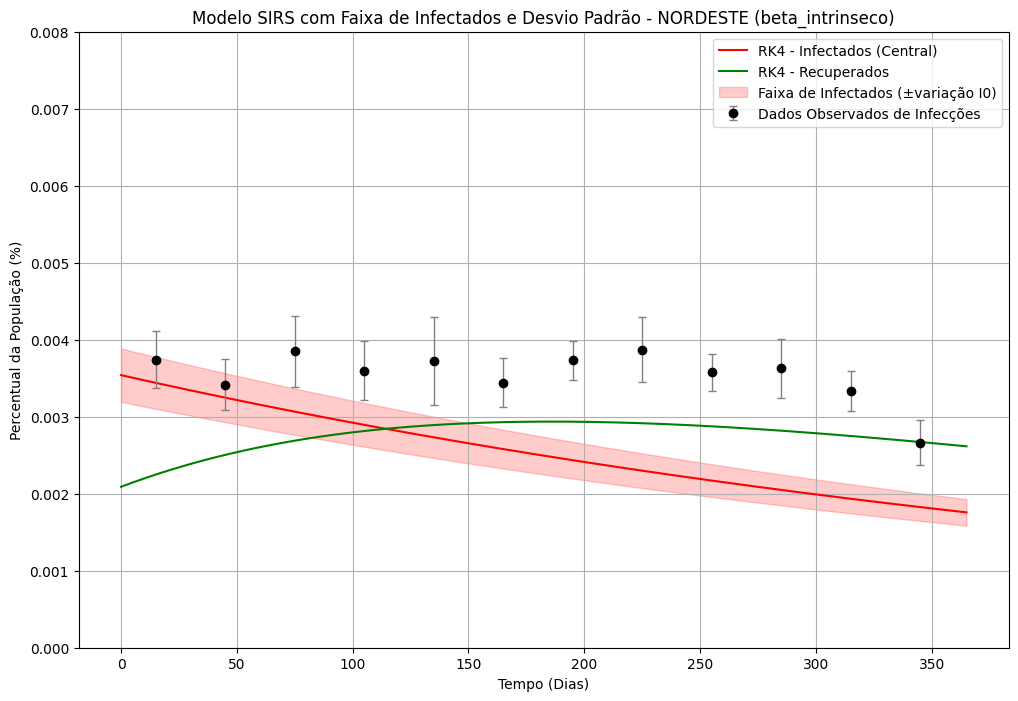

Gr√°fico salvo em: SUDESTE_SIRS_beta_intrinseco_plot.png


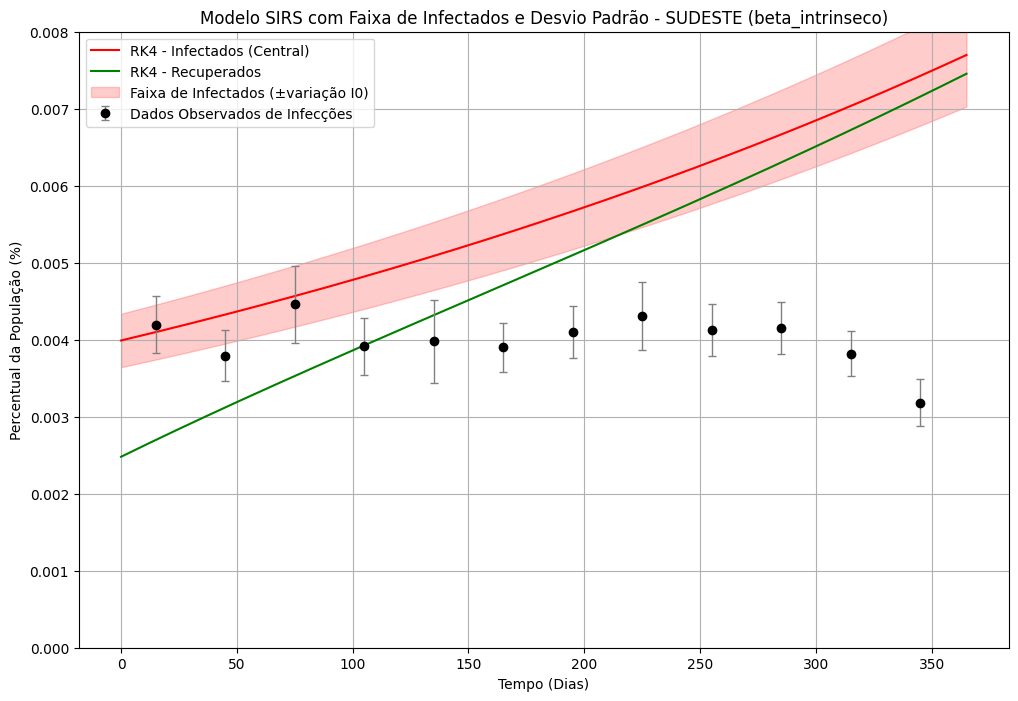

Gr√°fico salvo em: SUL_SIRS_beta_intrinseco_plot.png


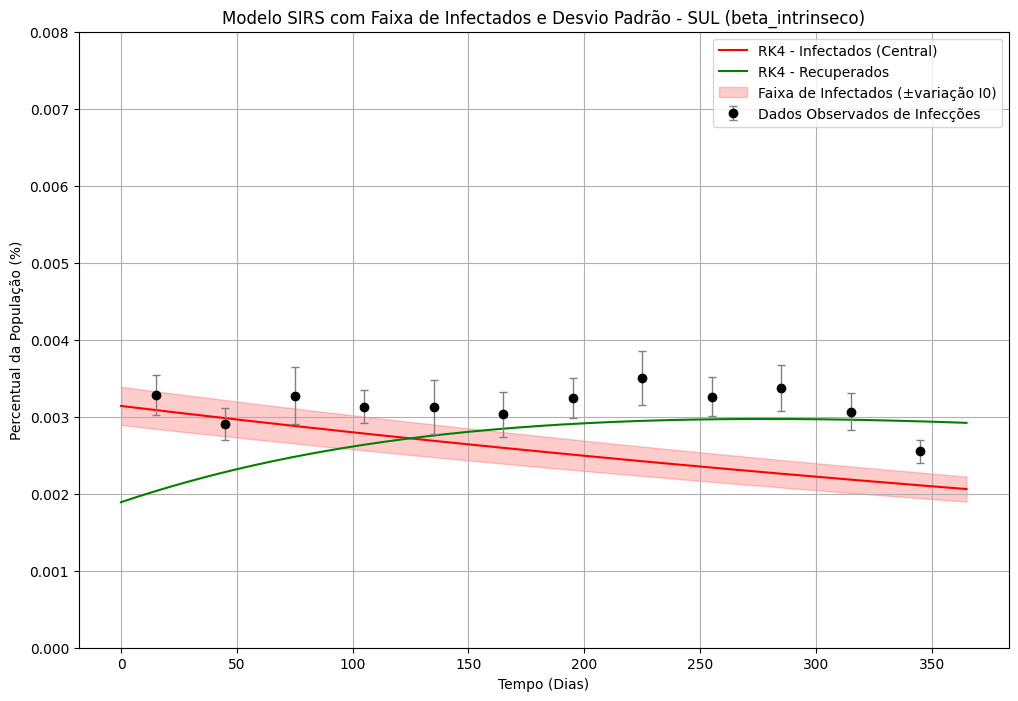

Gr√°fico salvo em: CENTROOESTE_SIRS_beta_intrinseco_plot.png


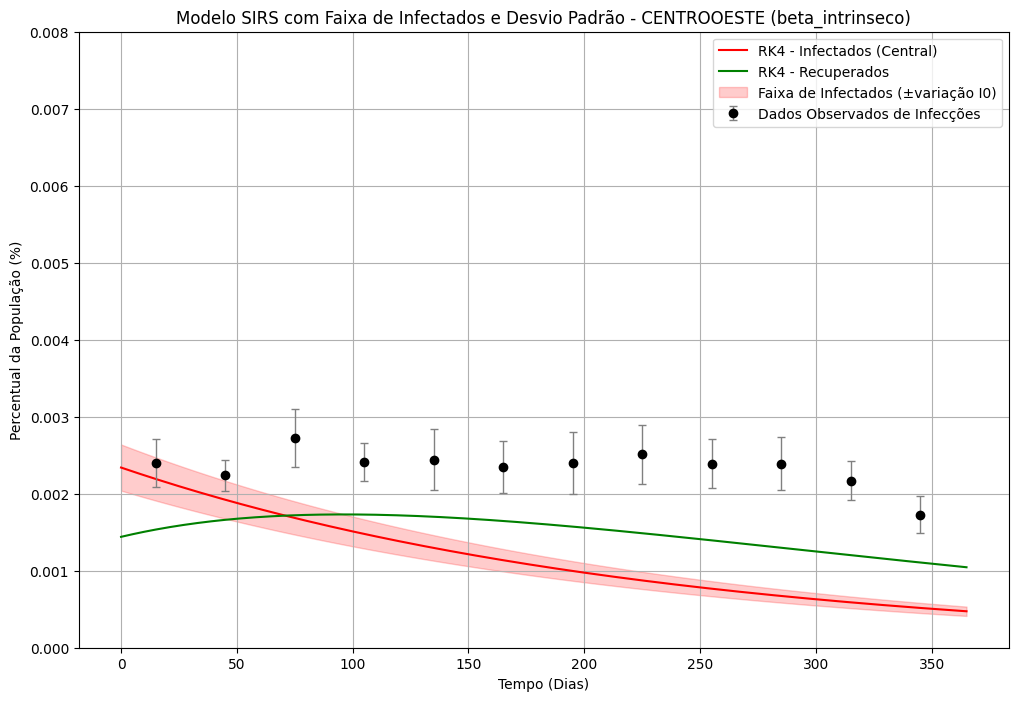

In [13]:
# Fun√ß√£o para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equa√ß√µes SIRS.
    
    Par√¢metros:
    - S: Popula√ß√£o suscet√≠vel (%)
    - I: Popula√ß√£o infectada (%)
    - R: Popula√ß√£o recuperada (%)
    - beta_f: Taxa de transmiss√£o
    - gamma_f: Taxa de recupera√ß√£o
    - mu_s: Taxa de mortalidade natural (suscet√≠veis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na popula√ß√£o
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscet√≠veis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# M√©todo de Runge-Kutta de 4¬™ Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Corre√ß√£o aqui

        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Par√¢metros de simula√ß√£o
t_max = 365  # Tempo m√°ximo de simula√ß√£o (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada regi√£o "Œ≤_intr√≠nseco": [0.008571, 0.010071, 0.013191, 0.010138, 0.007912]
beta_valores = {
    'NORTE': 0.008571,
    'NORDESTE': 0.010071,
    'SUDESTE': 0.013191,
    'SUL': 0.010138,
    'CENTROOESTE': 0.007912
}

# Definindo os valores de gamma para cada regi√£o
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada regi√£o
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada regi√£o
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada regi√£o
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada regi√£o
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada regi√£o
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de m√©dia de casos em percentual para cada regi√£o
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padr√£o de casos em percentual para cada regi√£o
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a varia√ß√£o de I0 para cada regi√£o (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gr√°ficos para cada regi√£o
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medi√ß√£o
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gr√°ficos para cada regi√£o com os pontos de dados observados nos dias de medi√ß√£o
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a regi√£o atual
    variacao_I0 = variacao_I0_valores[regiao]  # Varia√ß√£o de I0 para a regi√£o atual

    # Definindo dois valores de I0 para criar a faixa (¬±varia√ß√£o_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o m√©todo RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (¬±varia√ß√£o I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infec√ß√µes',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da Popula√ß√£o (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padr√£o - {regiao} (beta_intrinseco)')
    plt.legend()
    plt.grid(True)
    # Salvar o gr√°fico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_beta_intrinseco_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gr√°fico salvo em: {filename}')
    
    # Exibir o gr√°fico
    plt.show()

# Usando gamma_intrinseco no lugar do gamma no modelo SIRS

Gr√°fico salvo em: NORTE_SIRS_gamma_intrinseco_plot.png


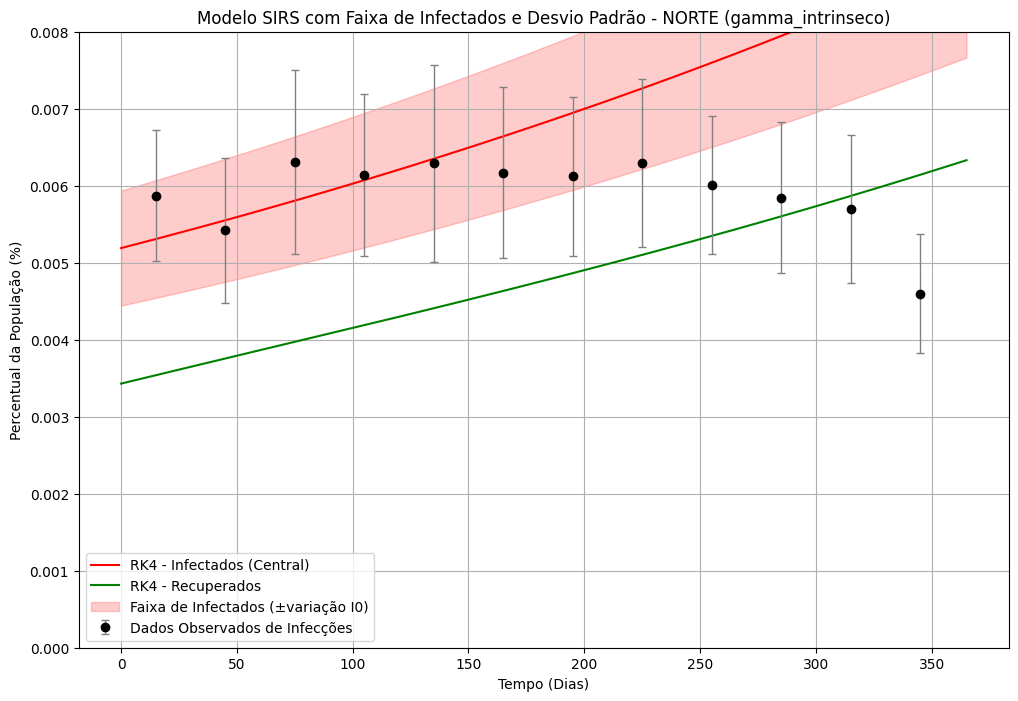

Gr√°fico salvo em: NORDESTE_SIRS_gamma_intrinseco_plot.png


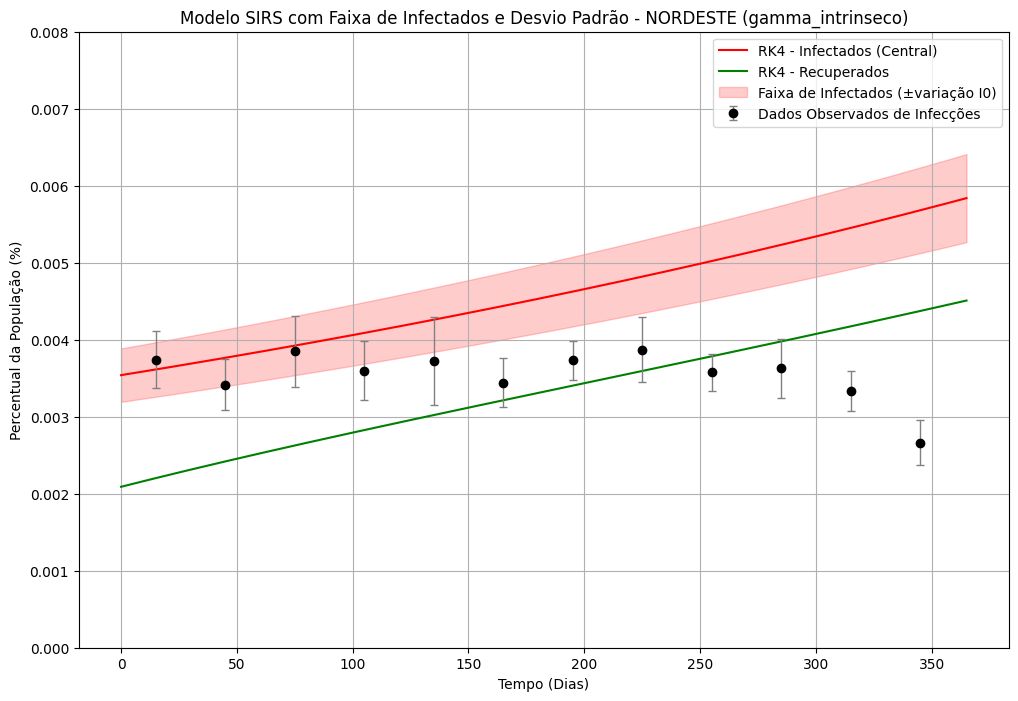

Gr√°fico salvo em: SUDESTE_SIRS_gamma_intrinseco_plot.png


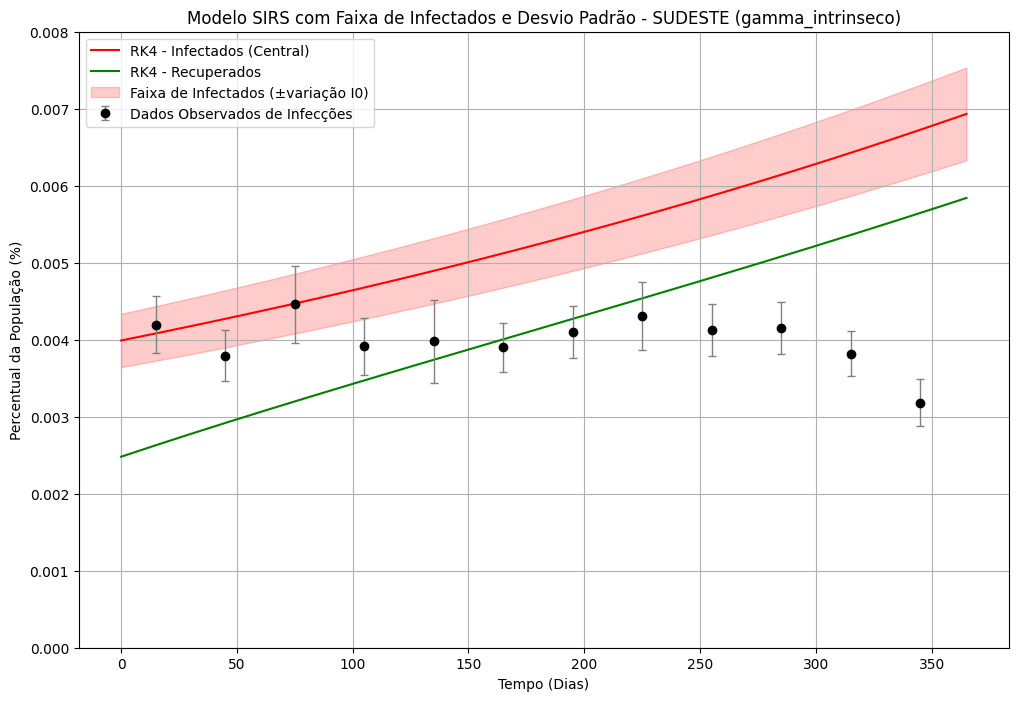

Gr√°fico salvo em: SUL_SIRS_gamma_intrinseco_plot.png


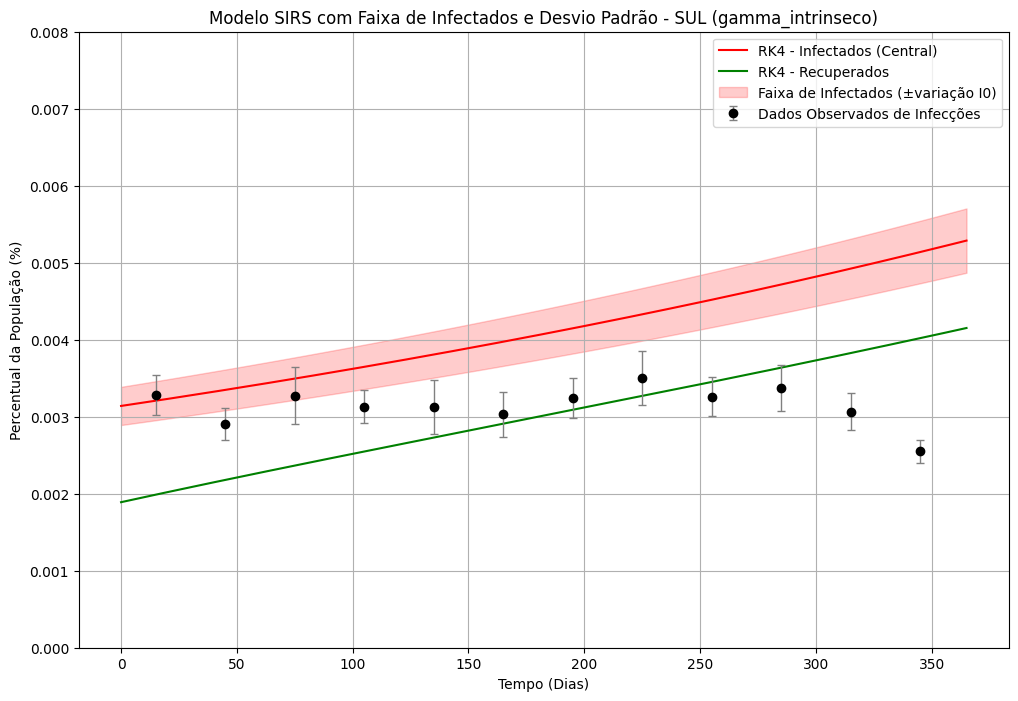

Gr√°fico salvo em: CENTROOESTE_SIRS_gamma_intrinseco_plot.png


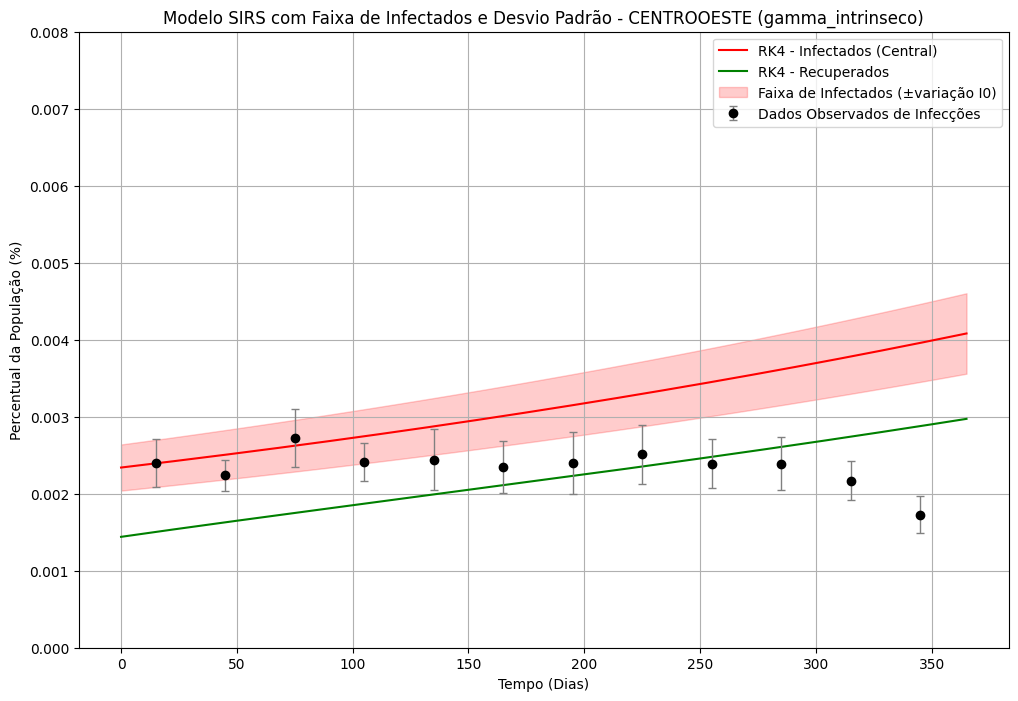

In [14]:
# Fun√ß√£o para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equa√ß√µes SIRS.
    
    Par√¢metros:
    - S: Popula√ß√£o suscet√≠vel (%)
    - I: Popula√ß√£o infectada (%)
    - R: Popula√ß√£o recuperada (%)
    - beta_f: Taxa de transmiss√£o
    - gamma_f: Taxa de recupera√ß√£o
    - mu_s: Taxa de mortalidade natural (suscet√≠veis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na popula√ß√£o
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscet√≠veis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# M√©todo de Runge-Kutta de 4¬™ Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Corre√ß√£o aqui

        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Par√¢metros de simula√ß√£o
t_max = 365  # Tempo m√°ximo de simula√ß√£o (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada regi√£o
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

# Definindo os valores de gamma para cada regi√£o
gamma_valores = {
    'NORTE': 0.006200,
    'NORDESTE': 0.005342,
    'SUDESTE': 0.005635,
    'SUL': 0.004871,
    'CENTROOESTE': 0.005502
}

# Definindo os valores de mu_i para cada regi√£o
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada regi√£o
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada regi√£o
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada regi√£o
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada regi√£o
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de m√©dia de casos em percentual para cada regi√£o
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padr√£o de casos em percentual para cada regi√£o
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a varia√ß√£o de I0 para cada regi√£o (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gr√°ficos para cada regi√£o
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medi√ß√£o
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gr√°ficos para cada regi√£o com os pontos de dados observados nos dias de medi√ß√£o
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a regi√£o atual
    variacao_I0 = variacao_I0_valores[regiao]  # Varia√ß√£o de I0 para a regi√£o atual

    # Definindo dois valores de I0 para criar a faixa (¬±varia√ß√£o_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o m√©todo RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (¬±varia√ß√£o I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infec√ß√µes',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da Popula√ß√£o (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padr√£o - {regiao} (gamma_intrinseco)')
    plt.legend()
    plt.grid(True)
    # Salvar o gr√°fico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_gamma_intrinseco_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gr√°fico salvo em: {filename}')
    
    # Exibir o gr√°fico
    plt.show()

# Usando beta_intrinseco e gamma_intrinseco no lugar do beta e gamma no modelo SIRS

Gr√°fico salvo em: NORTE_SIRS_beta_e_gamma_intrinsecos_plot.png


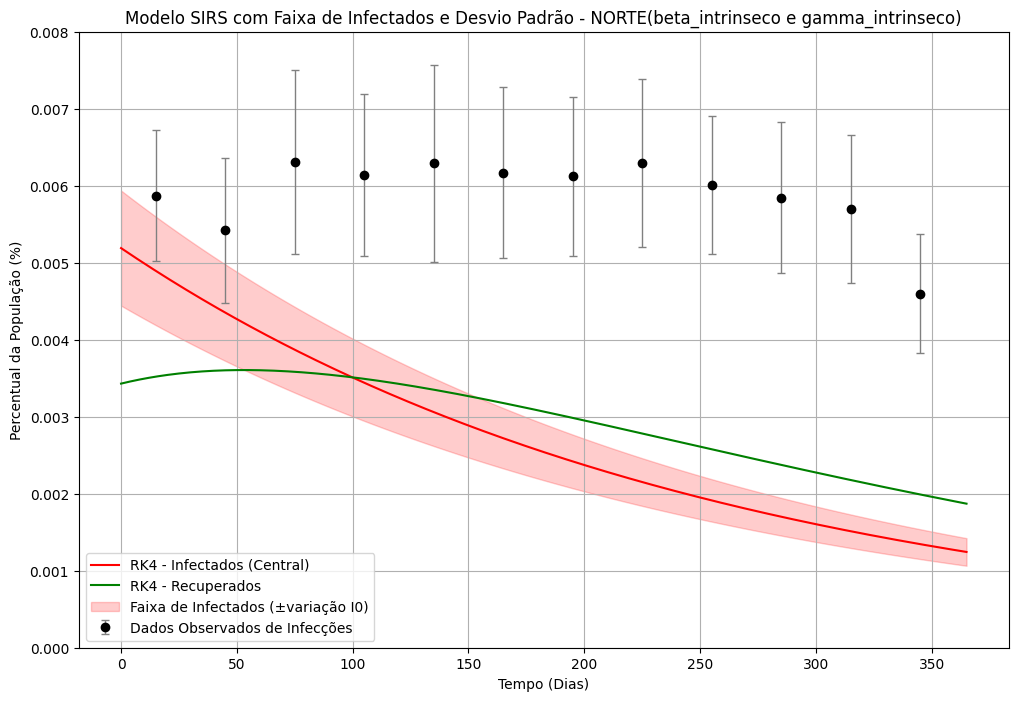

Gr√°fico salvo em: NORDESTE_SIRS_beta_e_gamma_intrinsecos_plot.png


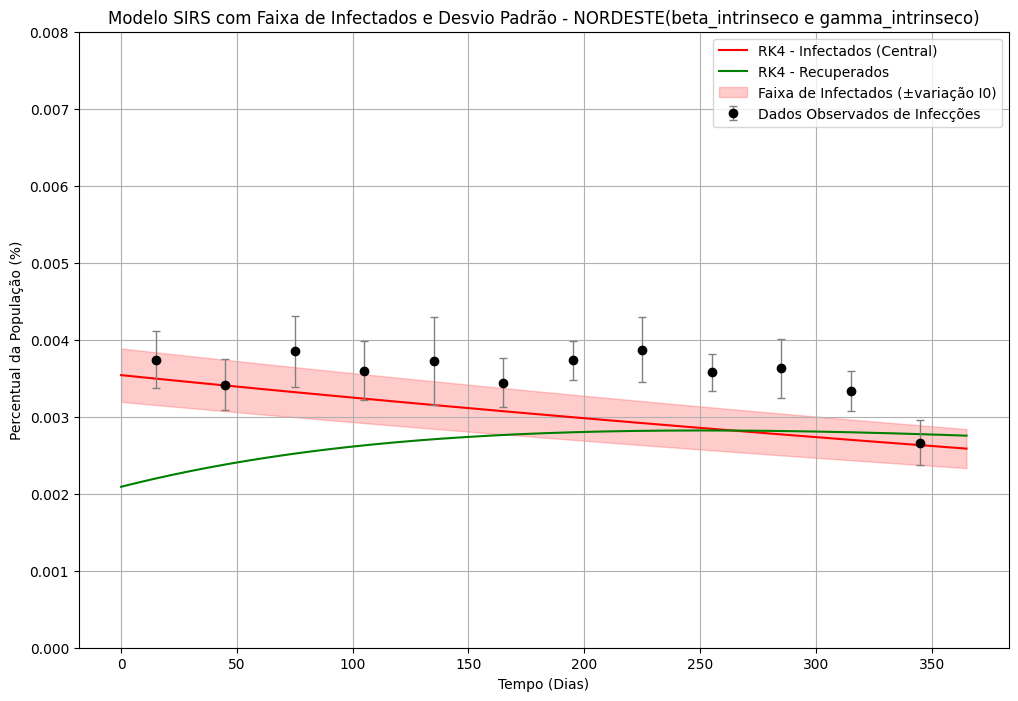

Gr√°fico salvo em: SUDESTE_SIRS_beta_e_gamma_intrinsecos_plot.png


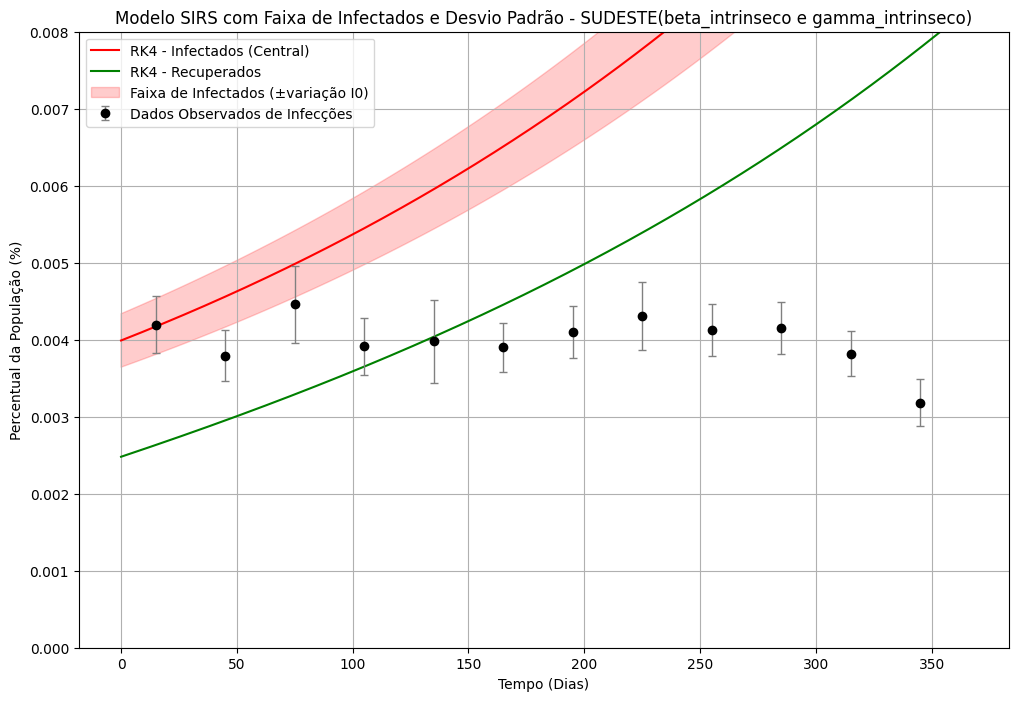

Gr√°fico salvo em: SUL_SIRS_beta_e_gamma_intrinsecos_plot.png


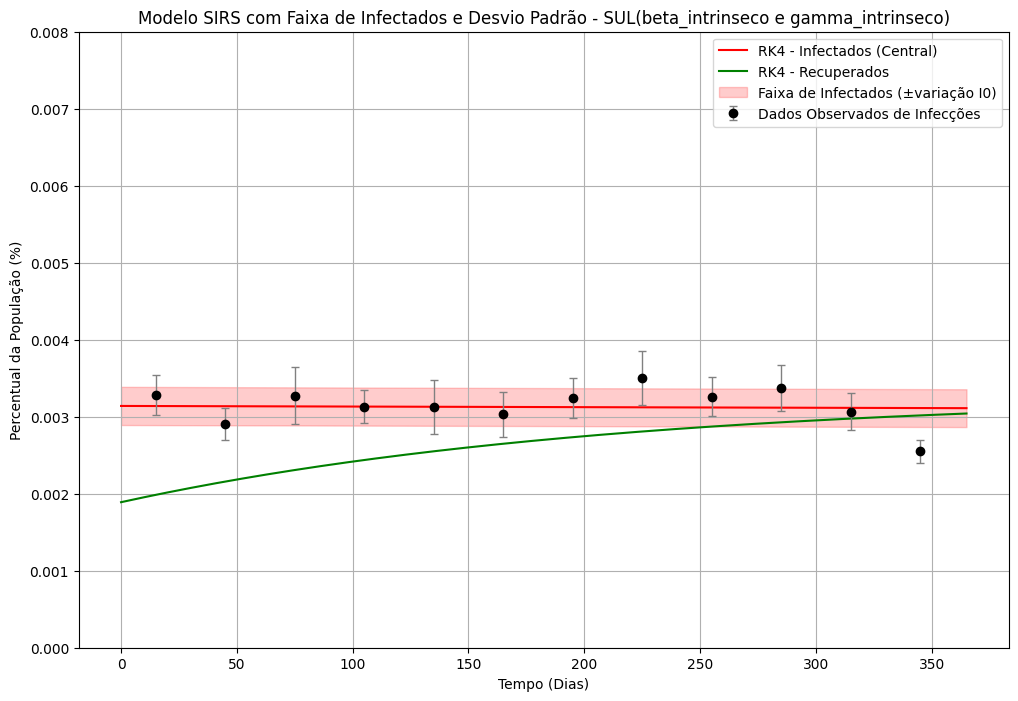

Gr√°fico salvo em: CENTROOESTE_SIRS_beta_e_gamma_intrinsecos_plot.png


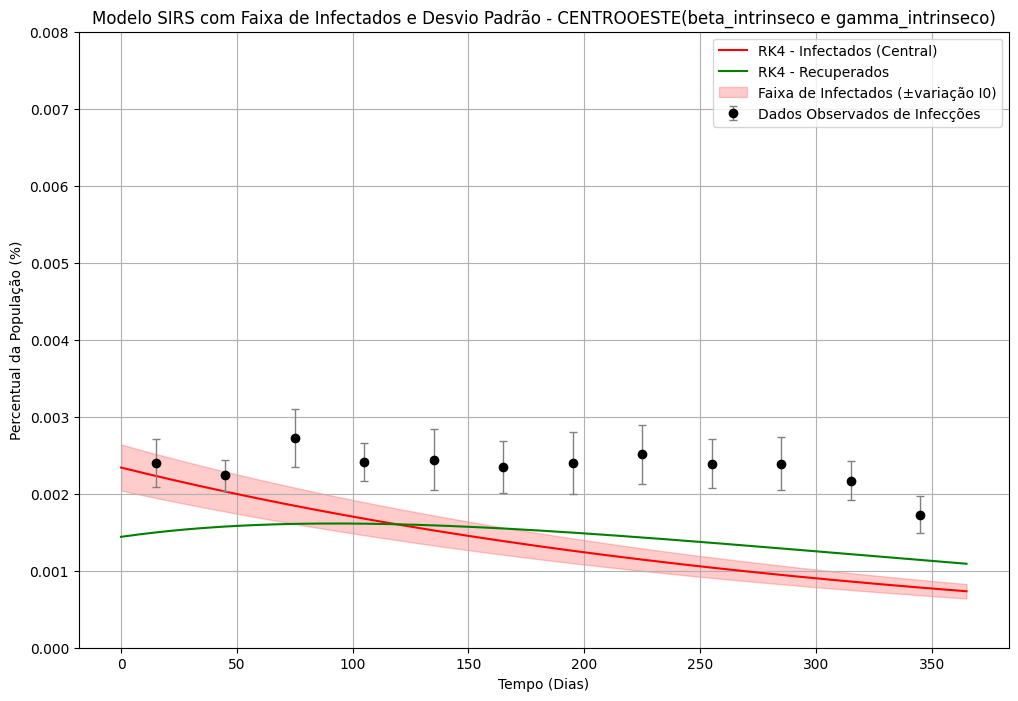

In [15]:
# Fun√ß√£o para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equa√ß√µes SIRS.
    
    Par√¢metros:
    - S: Popula√ß√£o suscet√≠vel (%)
    - I: Popula√ß√£o infectada (%)
    - R: Popula√ß√£o recuperada (%)
    - beta_f: Taxa de transmiss√£o
    - gamma_f: Taxa de recupera√ß√£o
    - mu_s: Taxa de mortalidade natural (suscet√≠veis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na popula√ß√£o
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscet√≠veis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# M√©todo de Runge-Kutta de 4¬™ Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Corre√ß√£o aqui

        # Normaliza√ß√£o para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Par√¢metros de simula√ß√£o
t_max = 365  # Tempo m√°ximo de simula√ß√£o (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada regi√£o
beta_valores = {
    'NORTE': 0.008571,
    'NORDESTE': 0.010071,
    'SUDESTE': 0.013191,
    'SUL': 0.010138,
    'CENTROOESTE': 0.007912
}

# Definindo os valores de gamma para cada regi√£o
gamma_valores = {
    'NORTE': 0.006200,
    'NORDESTE': 0.005342,
    'SUDESTE': 0.005635,
    'SUL': 0.004871,
    'CENTROOESTE': 0.005502
}

# Definindo os valores de mu_i para cada regi√£o
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada regi√£o
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada regi√£o
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada regi√£o
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada regi√£o
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de m√©dia de casos em percentual para cada regi√£o
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padr√£o de casos em percentual para cada regi√£o
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a varia√ß√£o de I0 para cada regi√£o (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gr√°ficos para cada regi√£o
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medi√ß√£o
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gr√°ficos para cada regi√£o com os pontos de dados observados nos dias de medi√ß√£o
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a regi√£o atual
    variacao_I0 = variacao_I0_valores[regiao]  # Varia√ß√£o de I0 para a regi√£o atual

    # Definindo dois valores de I0 para criar a faixa (¬±varia√ß√£o_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o m√©todo RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o m√©todo RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (¬±varia√ß√£o I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infec√ß√µes',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da Popula√ß√£o (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padr√£o - {regiao}(beta_intrinseco e gamma_intrinseco)')
    plt.legend()
    plt.grid(True)
    # Salvar o gr√°fico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_beta_e_gamma_intrinsecos_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gr√°fico salvo em: {filename}')
    
    # Exibir o gr√°fico
    plt.show()